In [296]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import seaborn as sns

import sys
sys.path.append('./python_files/')
import pickle

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_modules import View
from nn_models import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [297]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.5.0a0


In [298]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


## 0) Loading the data (MNIST or CIFAR-10)

In [299]:
train_input_full, train_target_full, test_input_full, test_target_full = load_data(cifar=False, normalize=True, flatten=False, full=True)

train_target_full = train_target_full.long()
test_target_full = test_target_full.long()

* Using MNIST
** Use 60000 train and 10000 test samples


In [300]:
print("shape of training samples :", train_input_full.shape)

shape of training samples : torch.Size([60000, 1, 28, 28])


In [301]:
nb_sample = 60000
train_input = train_input_full[0:nb_sample]
train_target = train_target_full[0:nb_sample]

test_input = test_input_full[0:nb_sample]
test_target = test_target_full[0:nb_sample]

In [302]:
print("shape of training samples :", train_input.shape)
print("shape of testing samples :", test_input.shape)

shape of training samples : torch.Size([60000, 1, 28, 28])
shape of testing samples : torch.Size([10000, 1, 28, 28])


In [303]:
computeClassesWeights(train_target)

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

In [304]:
computeClassesWeights(test_target)

tensor([0.0980, 0.1135, 0.1032, 0.1010, 0.0982, 0.0892, 0.0958, 0.1028, 0.0974,
        0.1009])

## 1) LeNet with disjoint trainset and testset (train 10 shadow models)

In [305]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [306]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

In [318]:
model = LeoNet()
load_from_memory = False

In [319]:
#debug_layers_dims(model, train_input.shape)

In [ ]:
if not load_from_memory:
    
    crit_fun = lambda input_, target : (input_, target)
    y_hat_fun = lambda y: y.argmax(1)
    #batch_cap = 60
    #batch_fun = lambda x, y: x - 2*(y // batch_cap) * batch_cap

    loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
    learning_rate = 0.1
    mt = ModelTrainer(model, loss_fun, optim.SGD(model.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
    hist = mt.fit(train_dataset, test_dataset, epochs=300, batch_size=10000, verbose=100)
    mt.plot_training("Learning curves")

training model 0
training model 1
training model 2
training model 3
training model 4
training model 5
training model 6
training model 7
training model 8
training model 9
training model 10
training model 11
training model 12
training model 13
training model 14
training model 15
training model 16
training model 17
training model 18
training model 19
training model 20


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


training model 21
training model 22
training model 23
training model 24
training model 25
training model 26
training model 27
training model 28
training model 29
training model 30
training model 31
training model 32
training model 33
training model 34
training model 35
training model 36
training model 37
training model 38
training model 39
training model 40
training model 41
training model 42
training model 43
training model 44
training model 45
training model 46
training model 47
training model 48
training model 49
training model 50
training model 51
training model 52
training model 53
training model 54
training model 55
training model 56
training model 57
training model 58
training model 59
training model 60
training model 61
training model 62
training model 63
training model 64
training model 65
training model 66
training model 67
training model 68
training model 69
training model 70
training model 71
training model 72
training model 73
training model 74
training model 75
training m

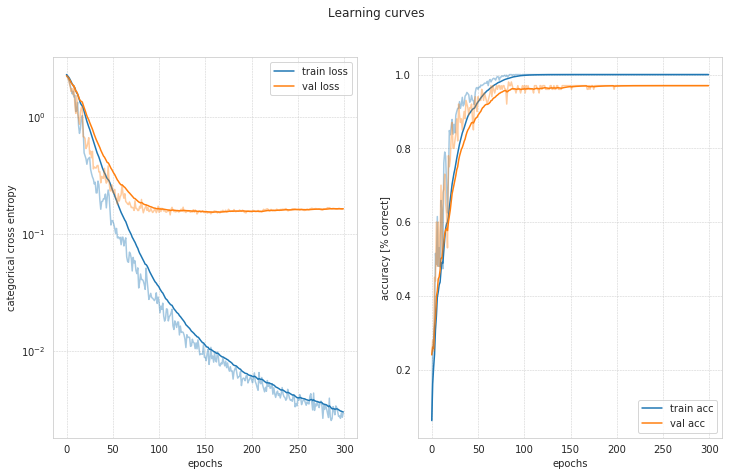

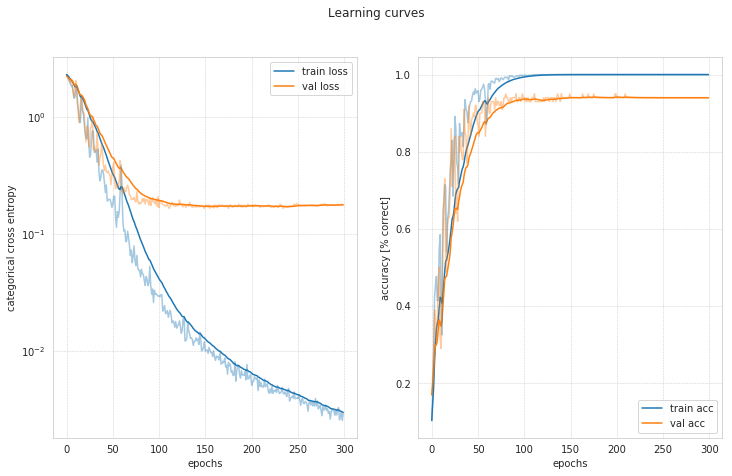

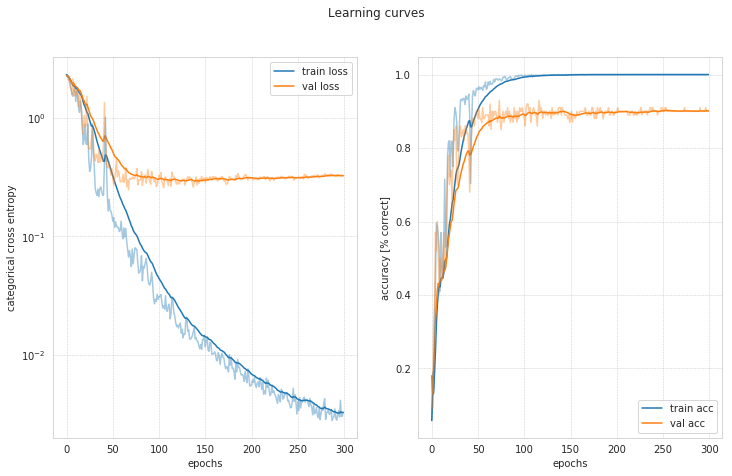

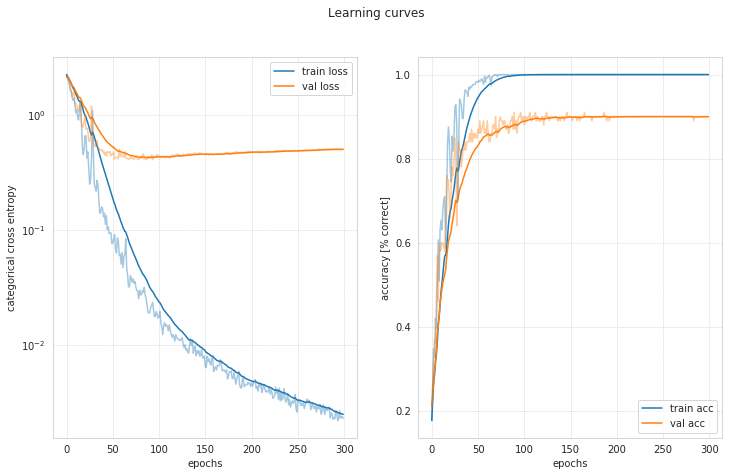

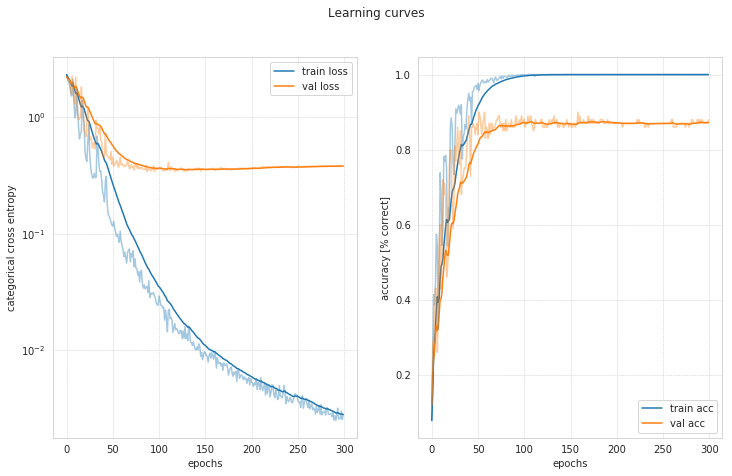

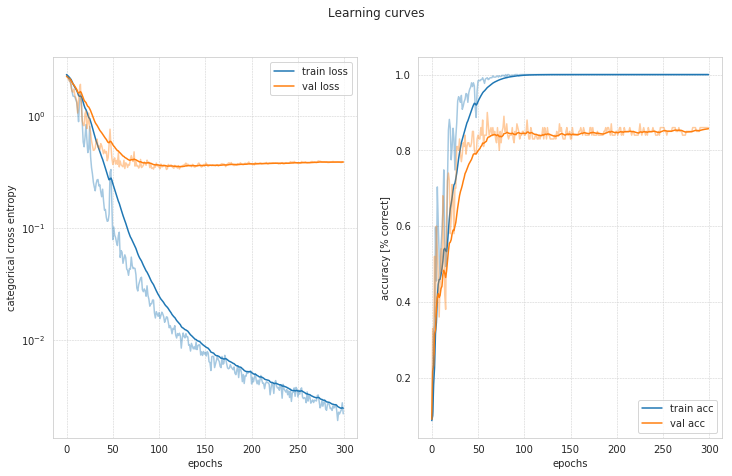

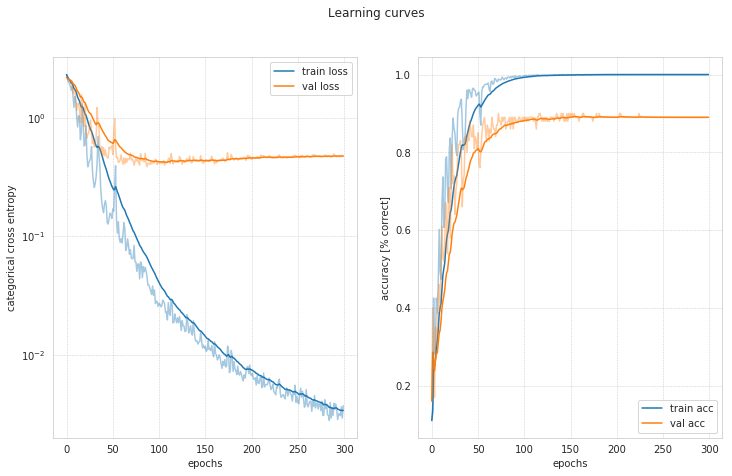

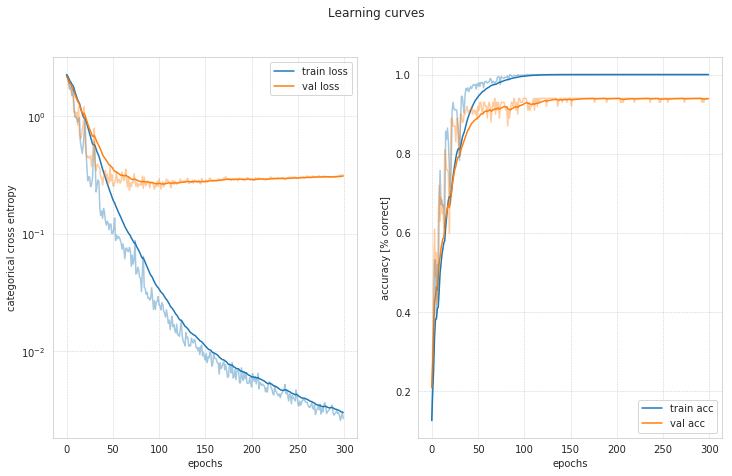

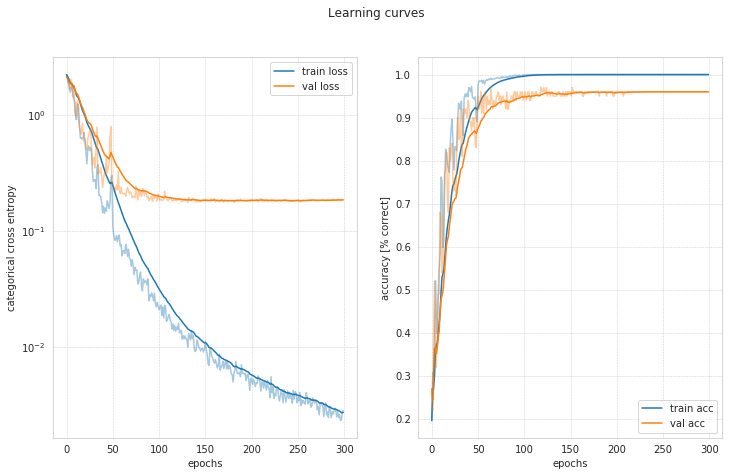

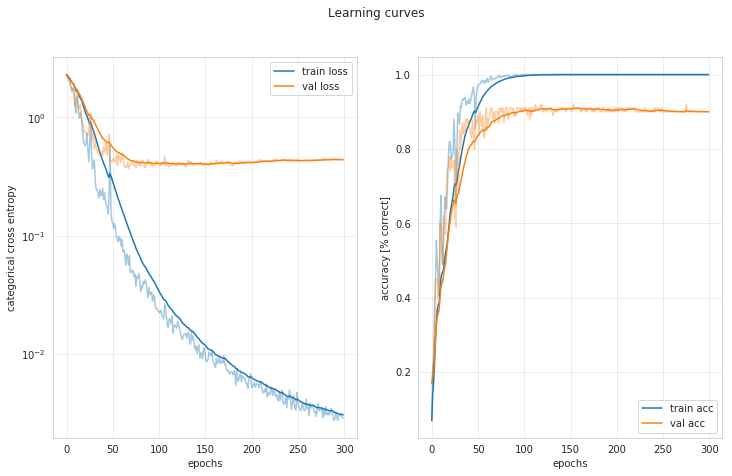

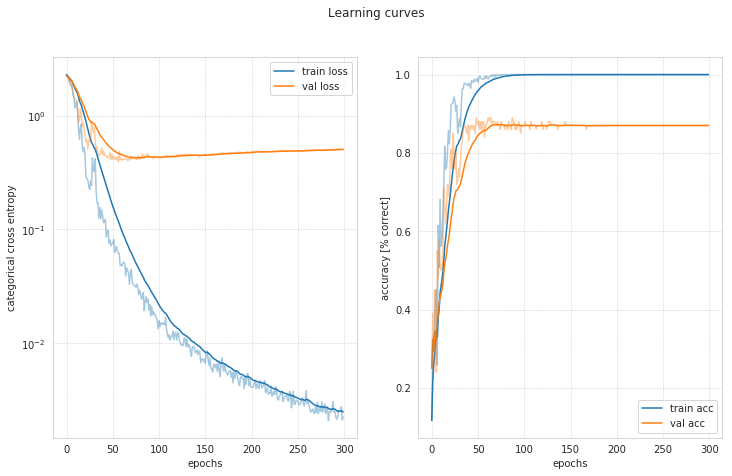

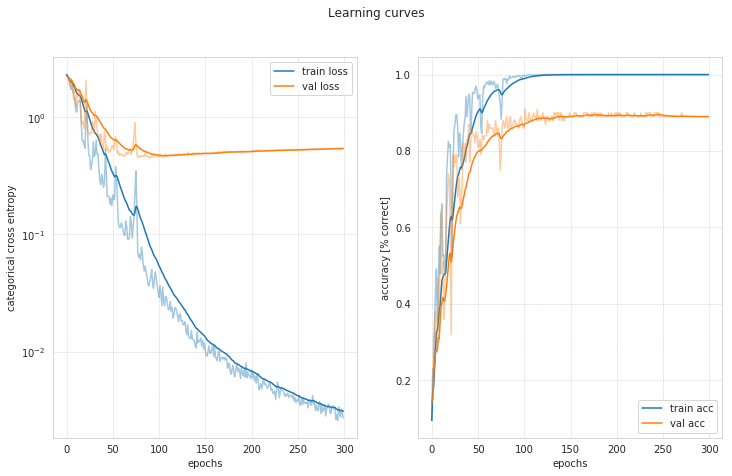

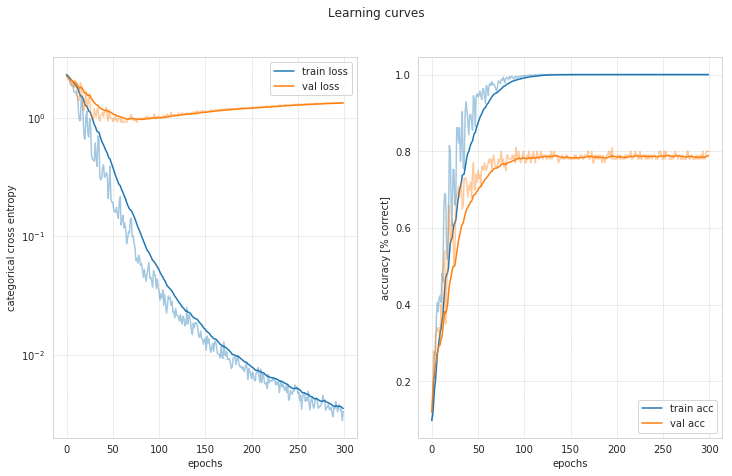

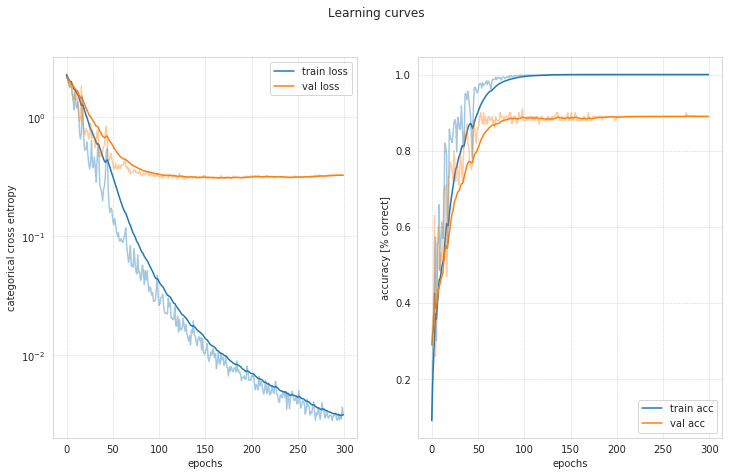

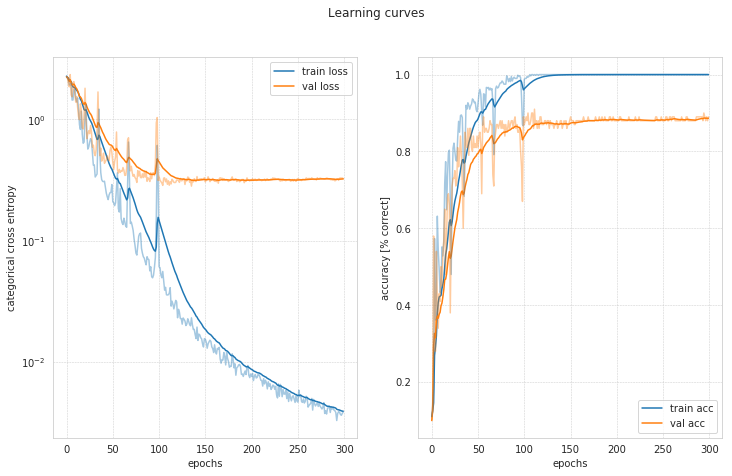

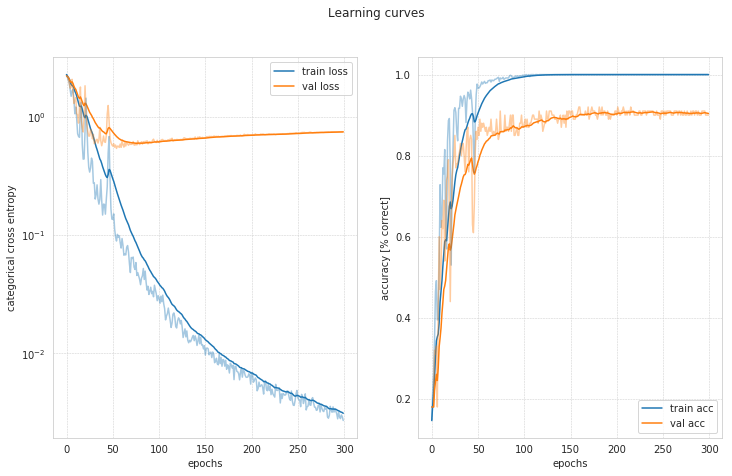

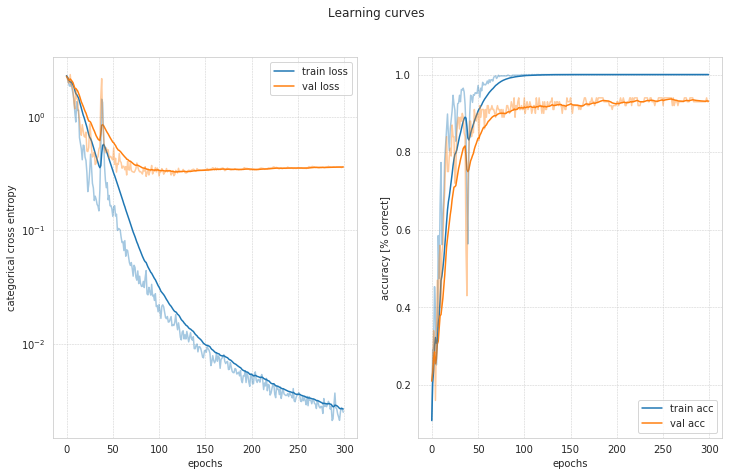

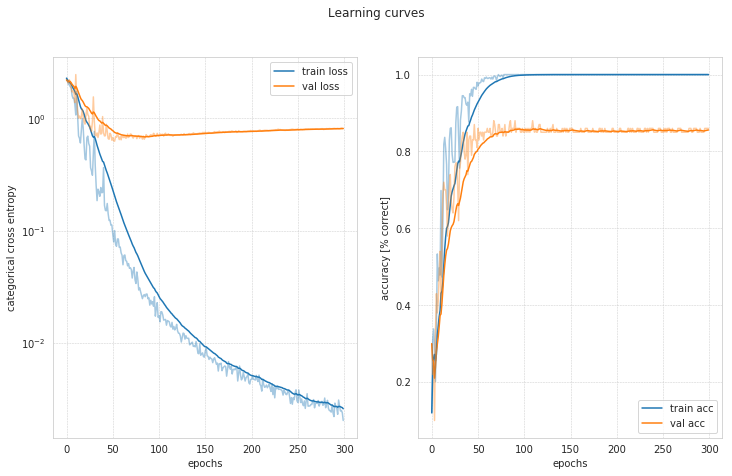

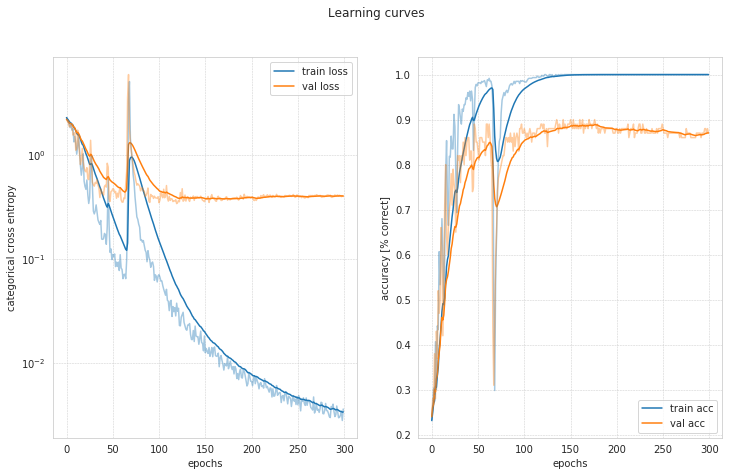

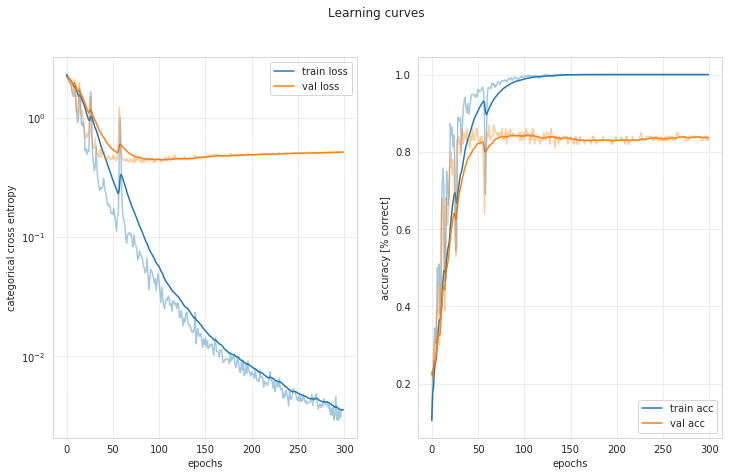

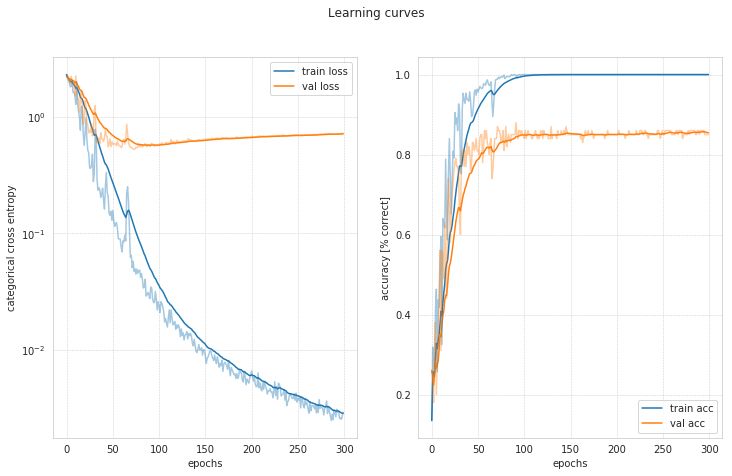

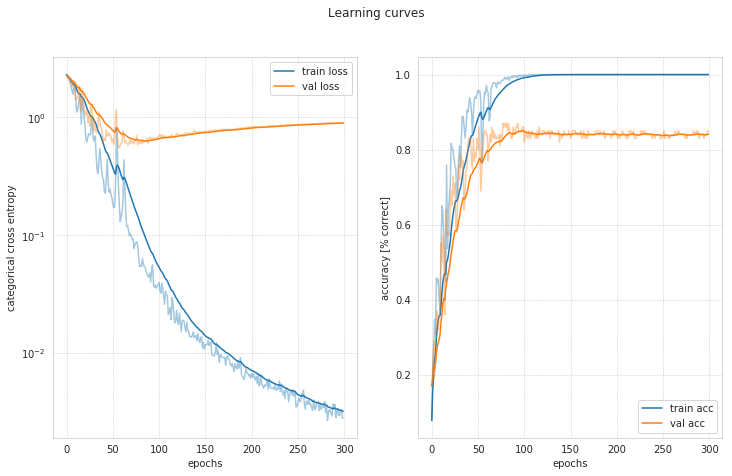

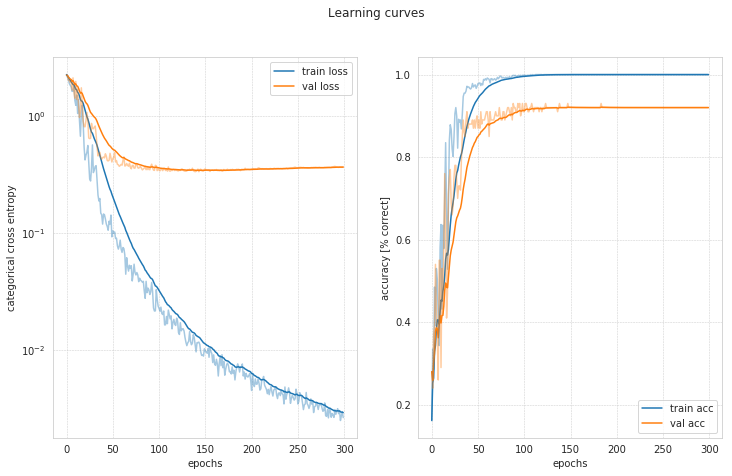

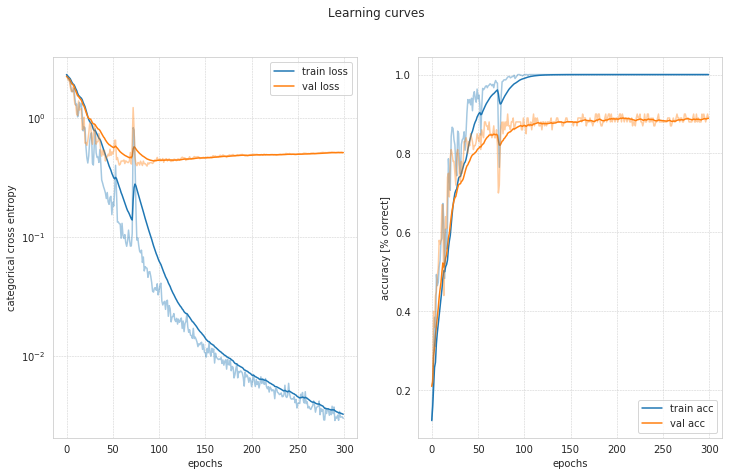

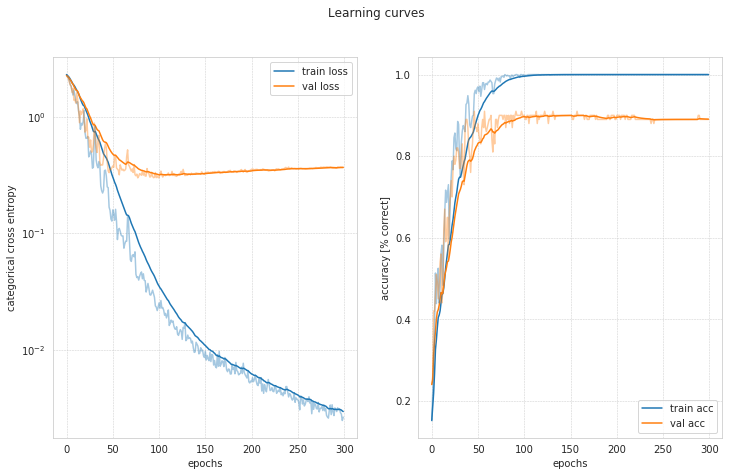

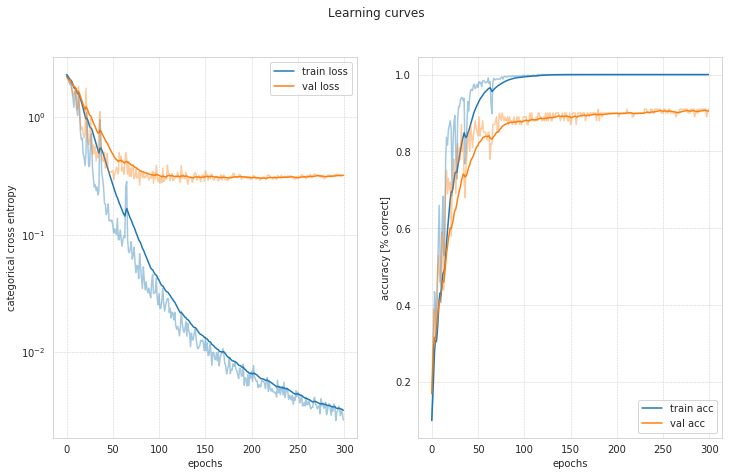

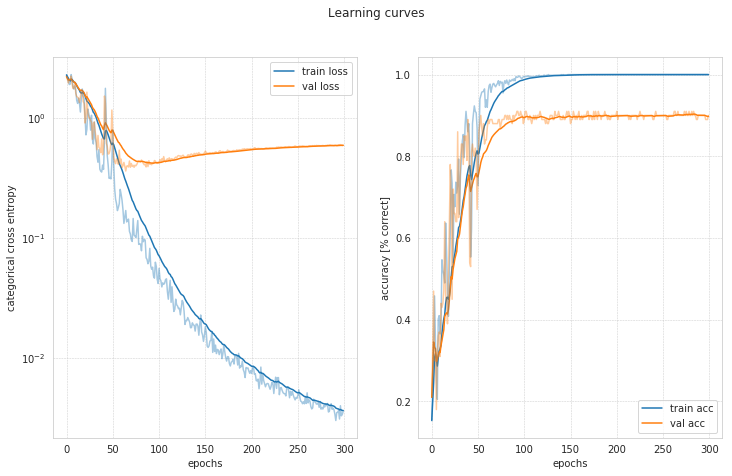

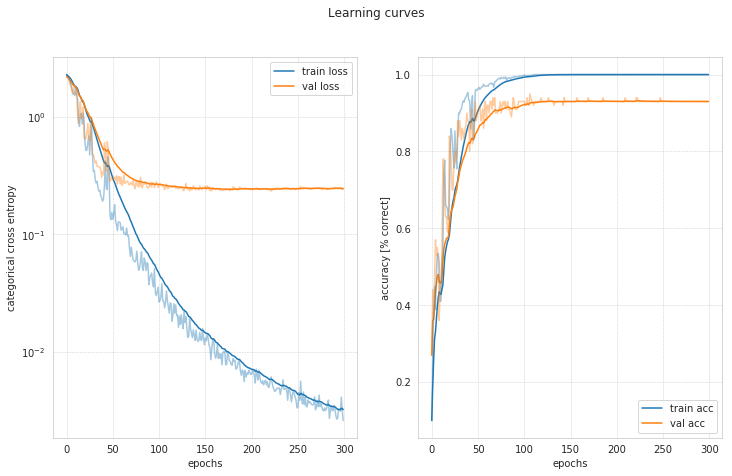

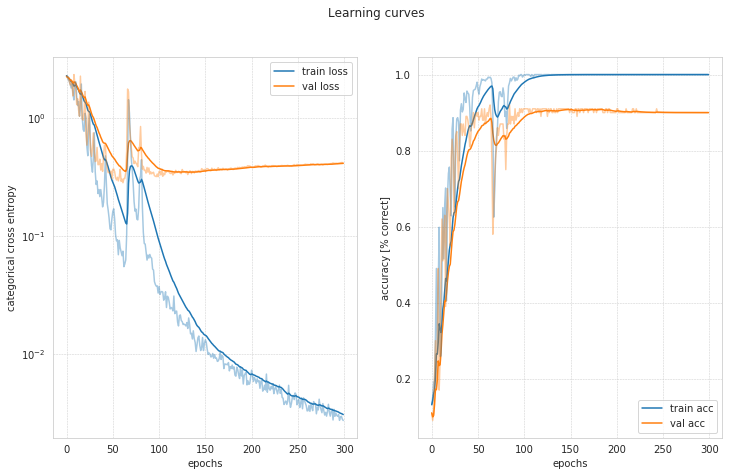

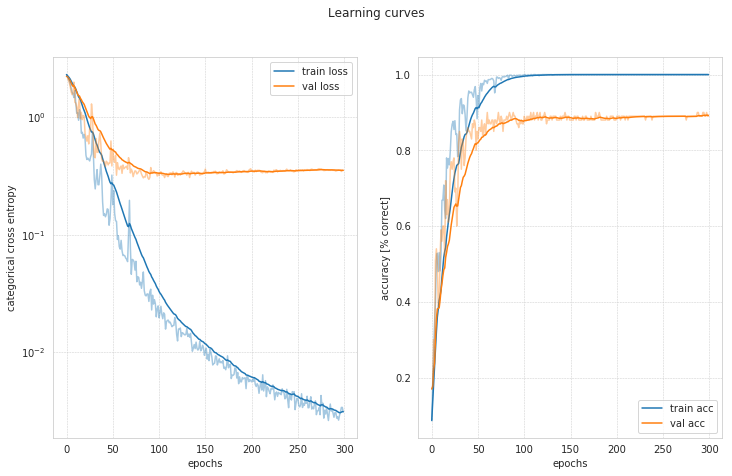

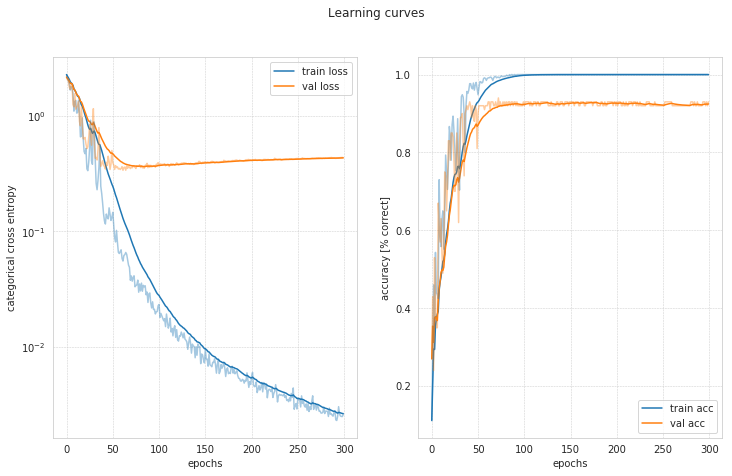

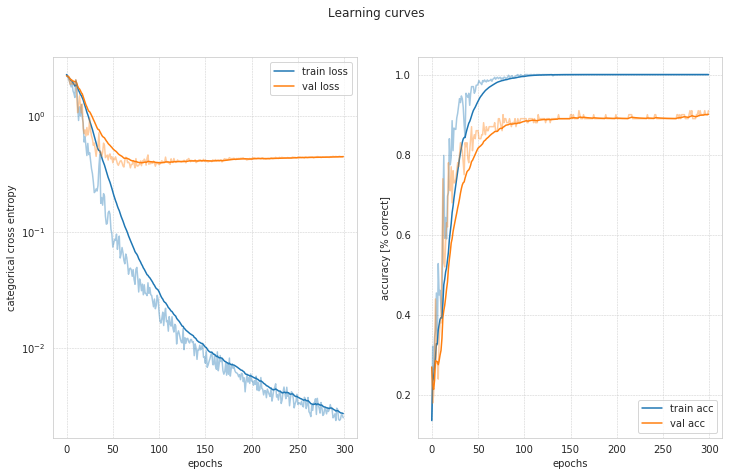

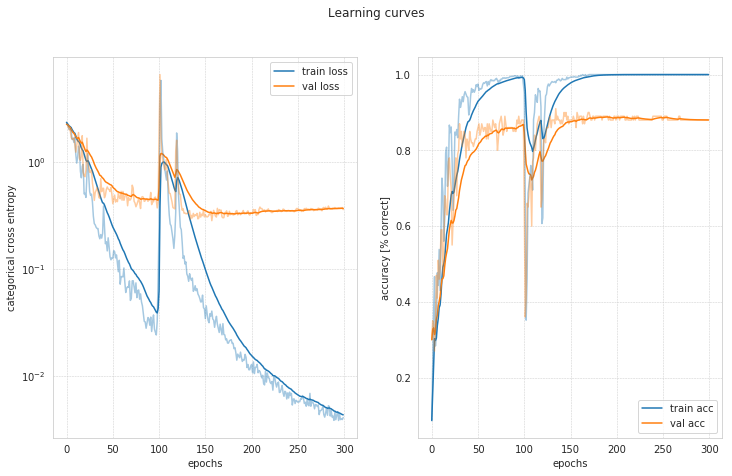

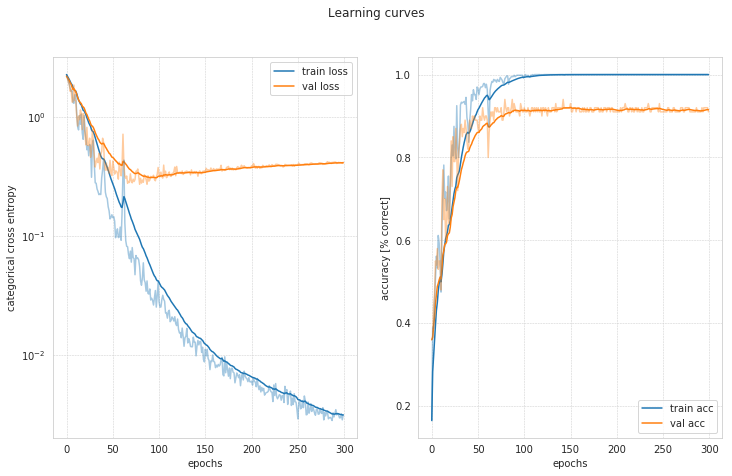

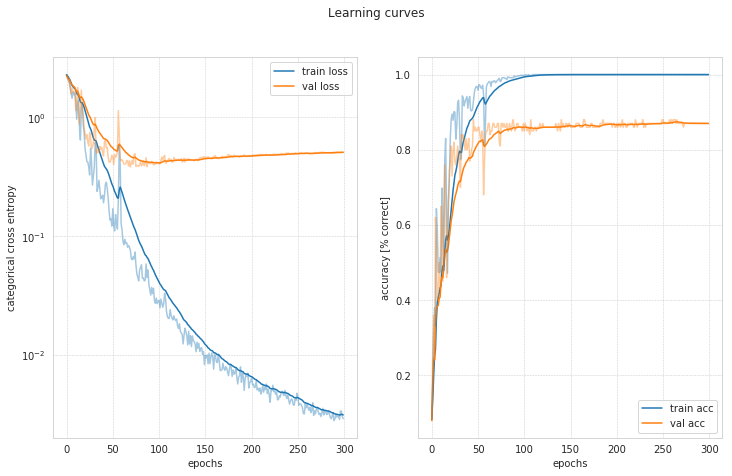

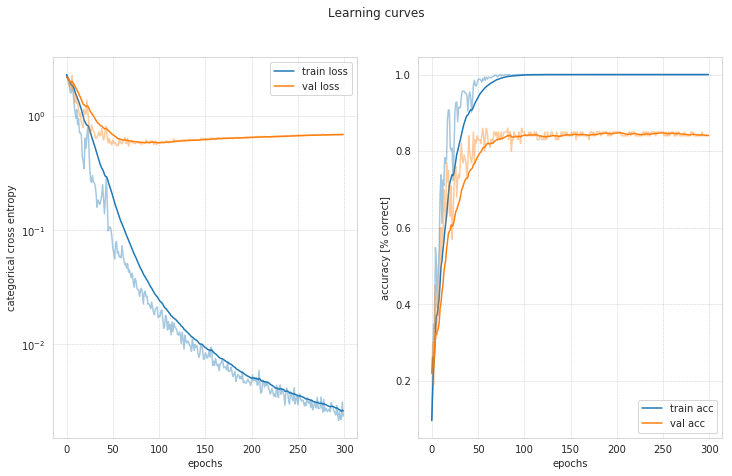

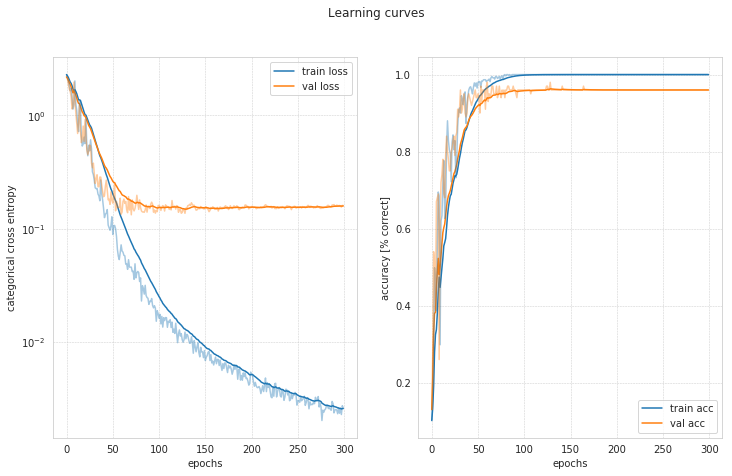

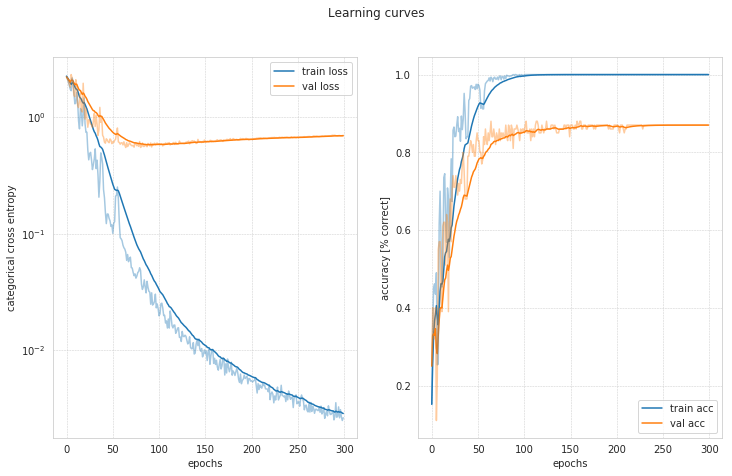

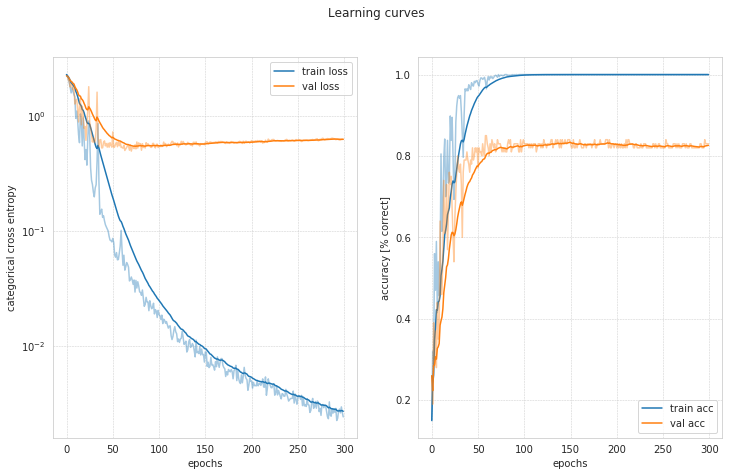

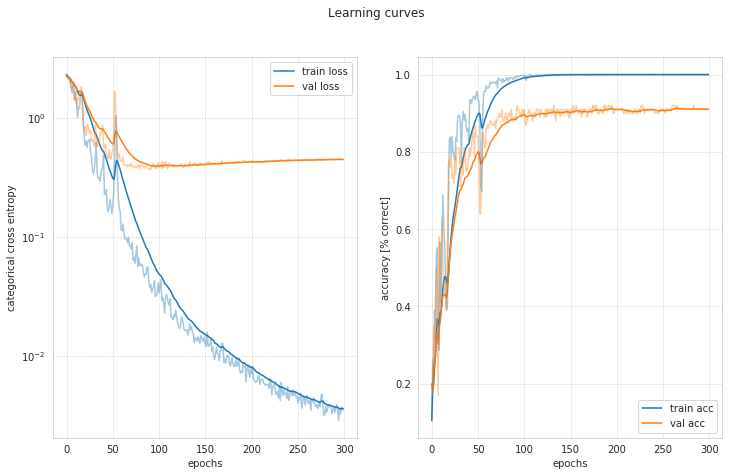

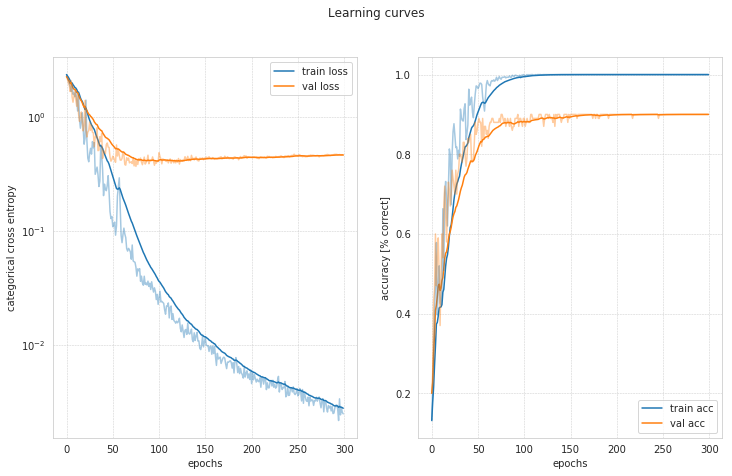

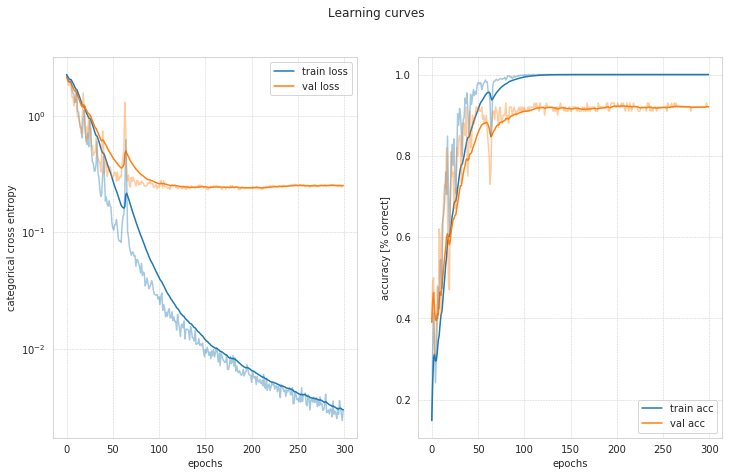

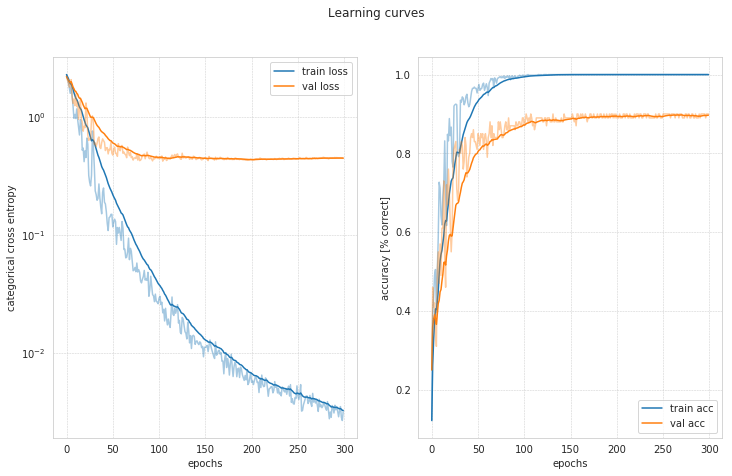

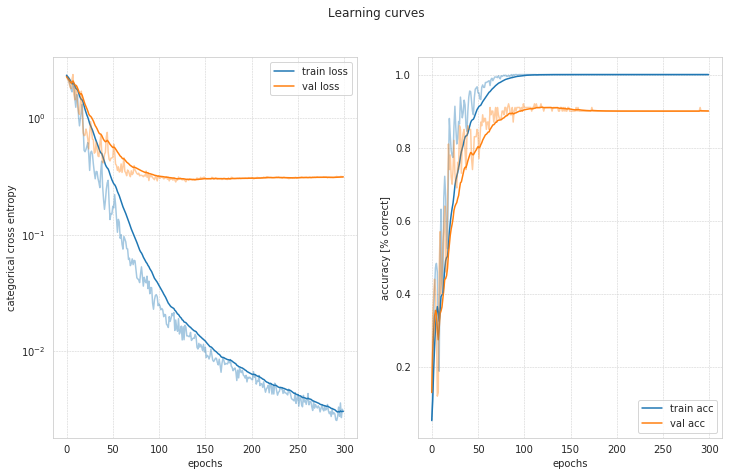

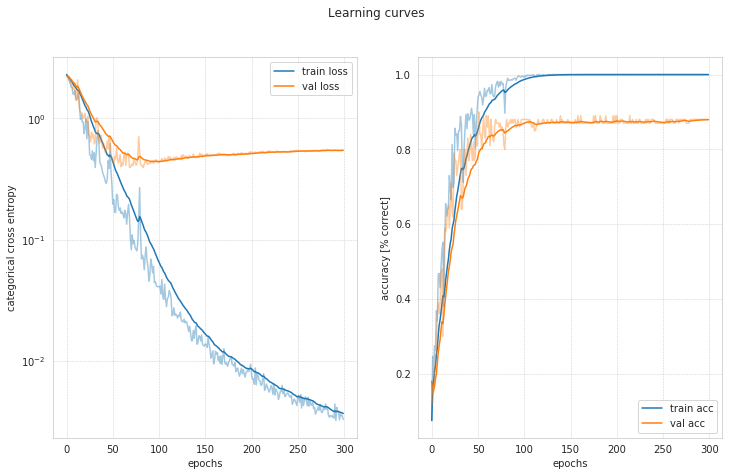

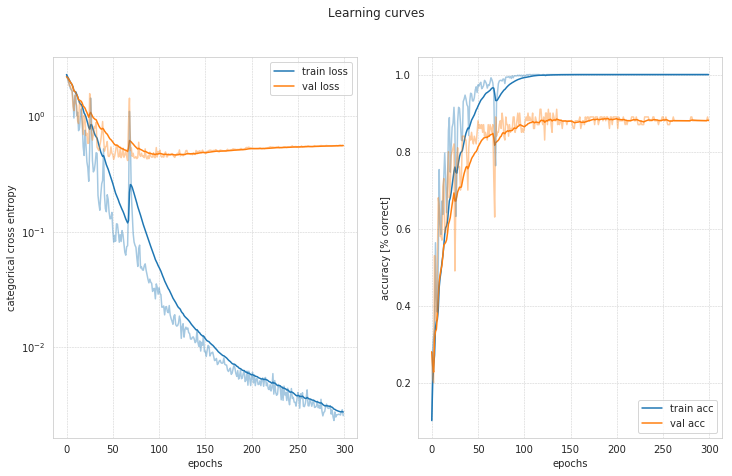

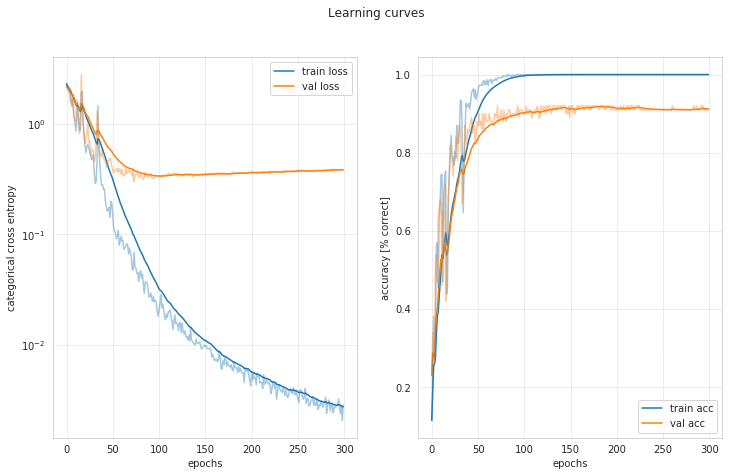

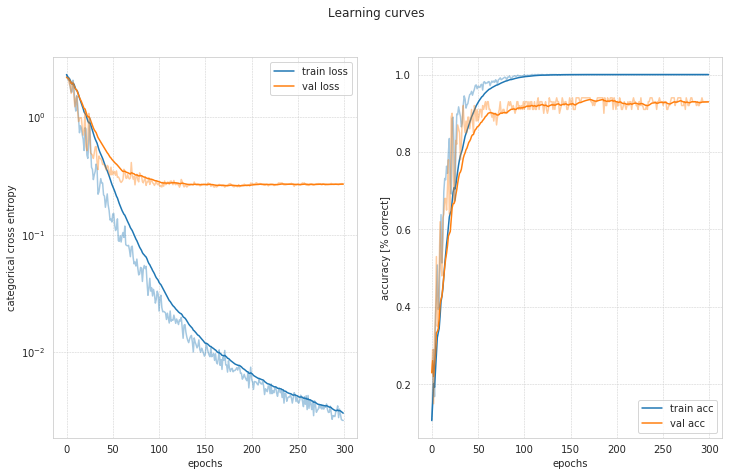

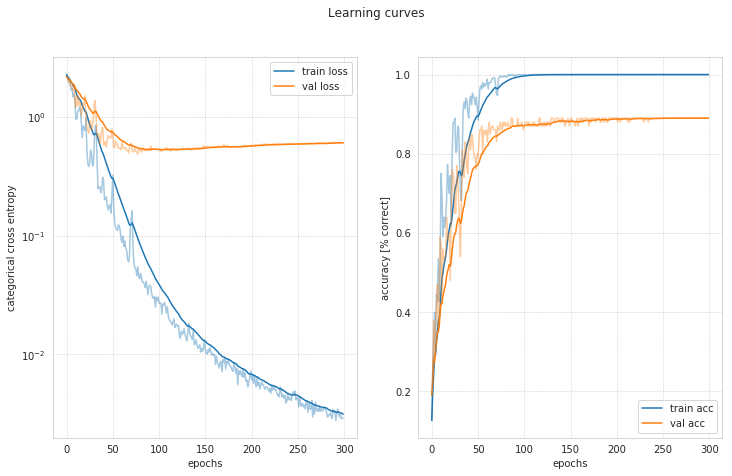

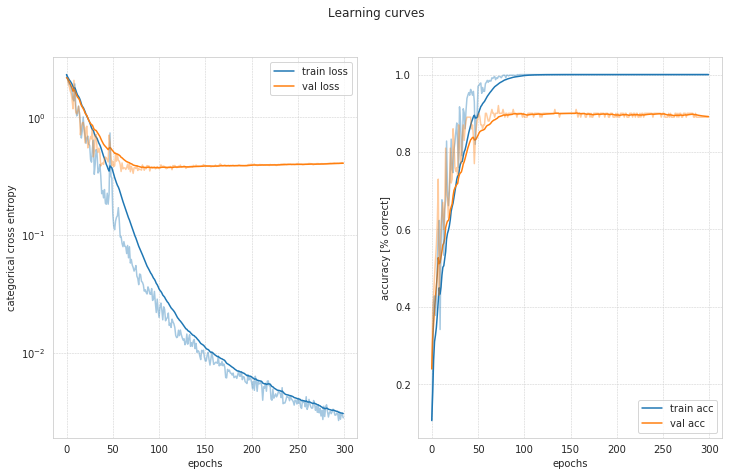

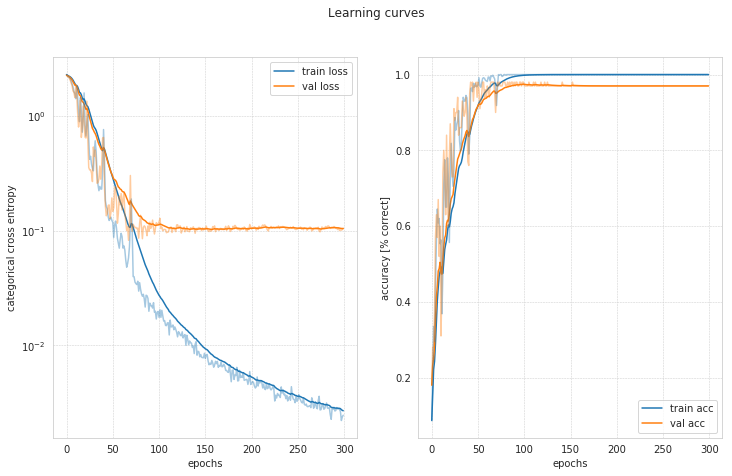

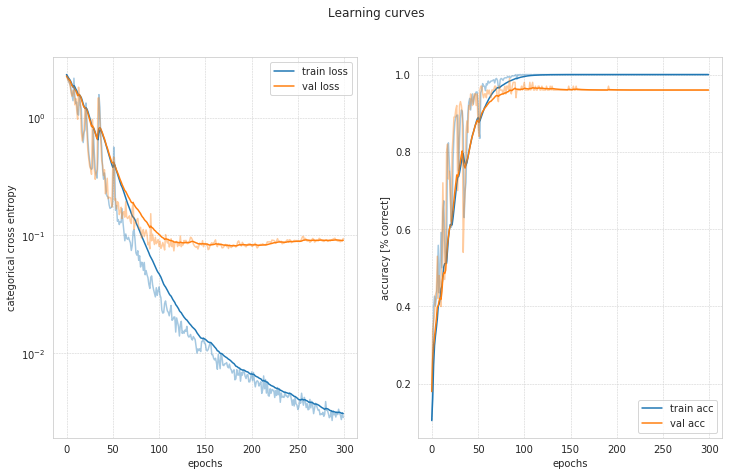

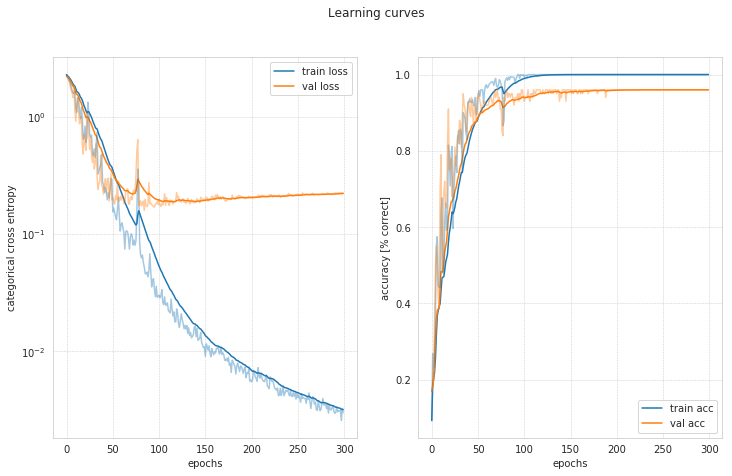

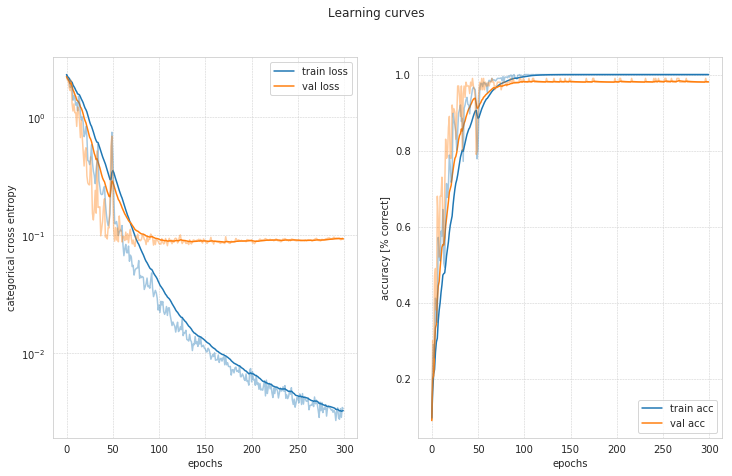

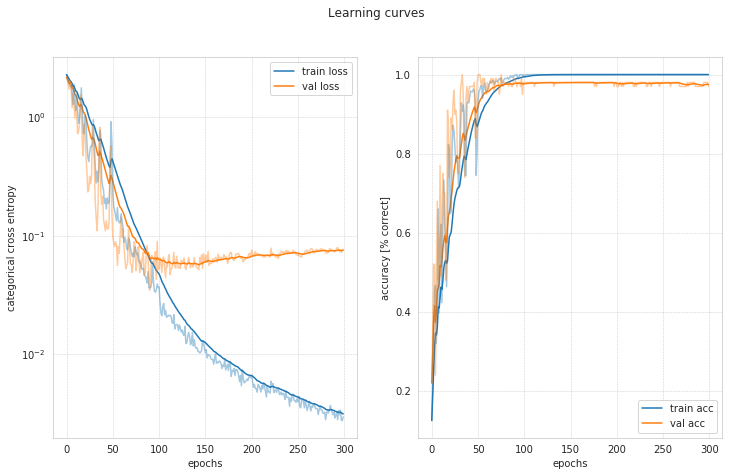

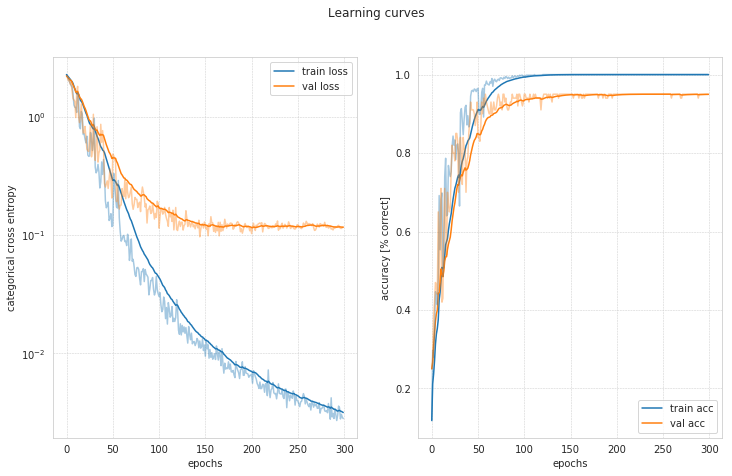

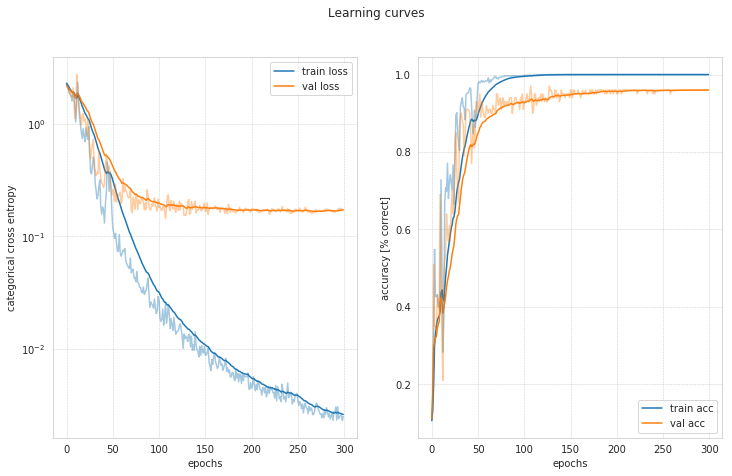

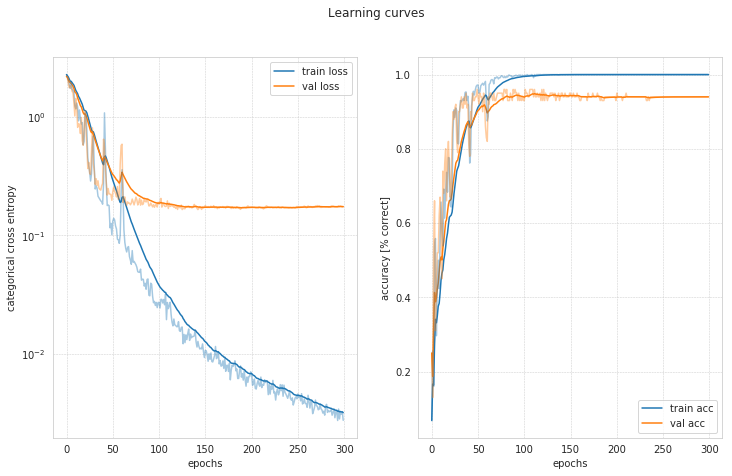

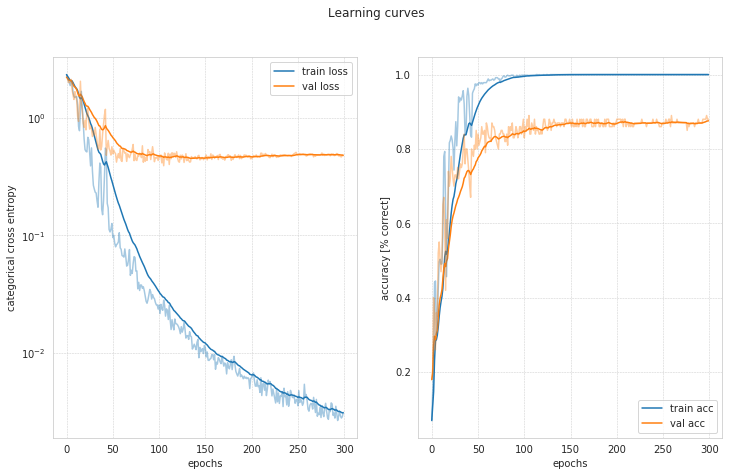

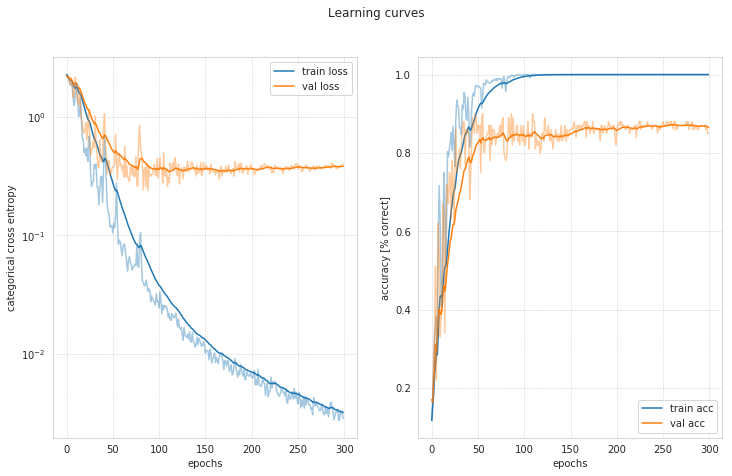

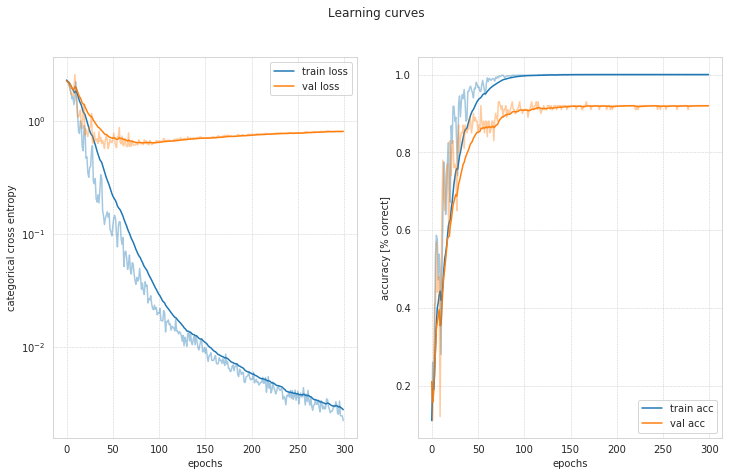

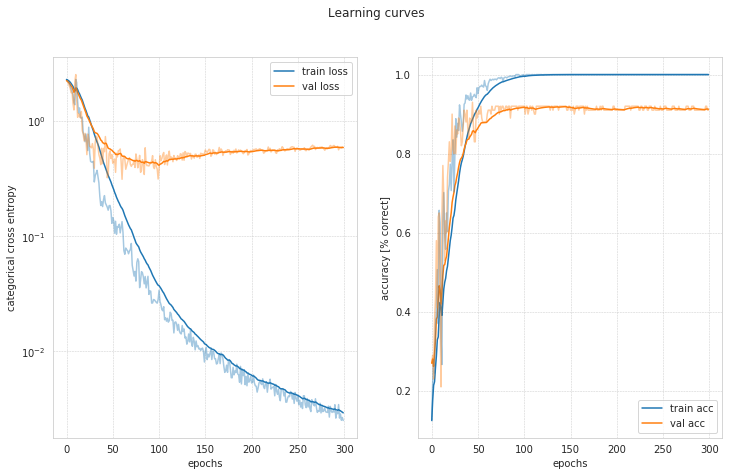

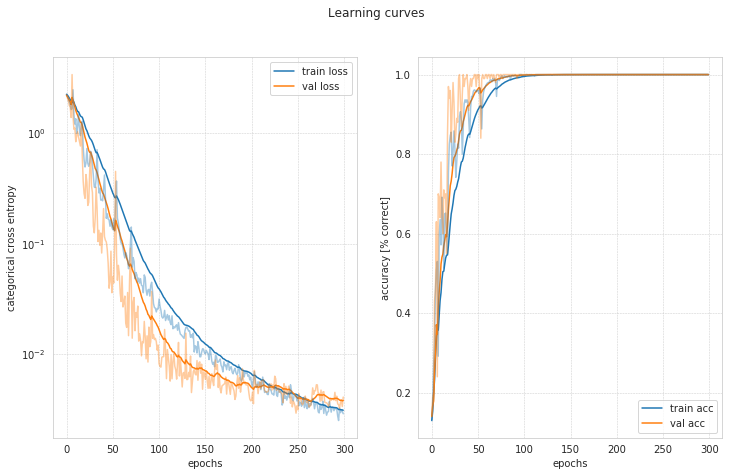

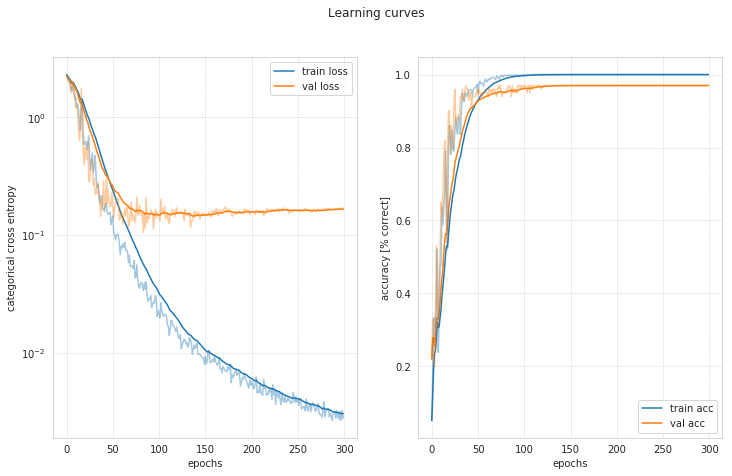

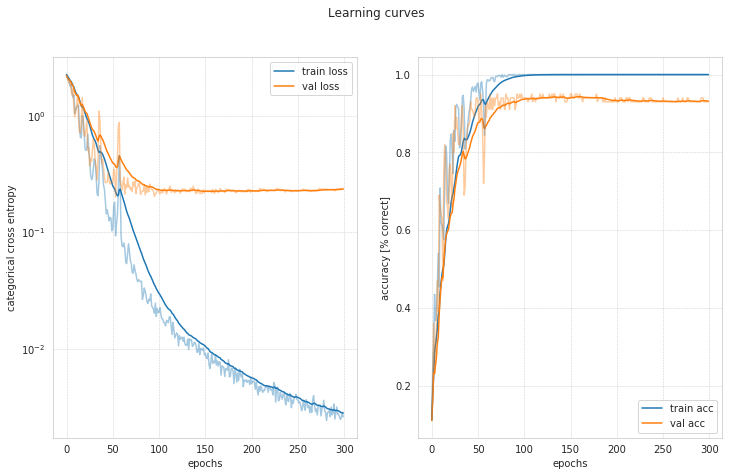

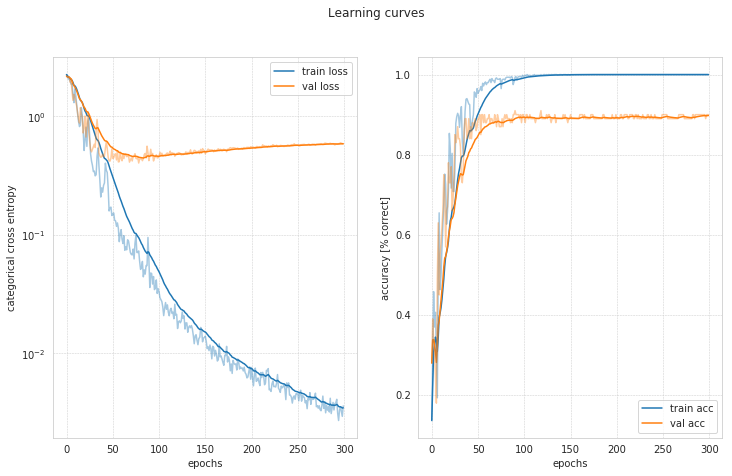

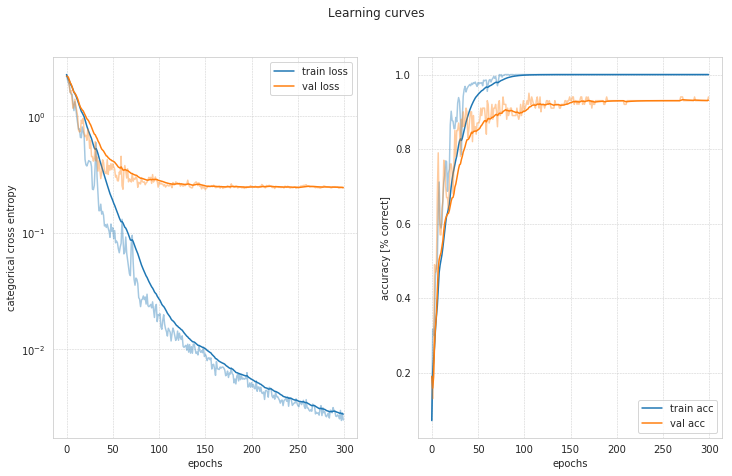

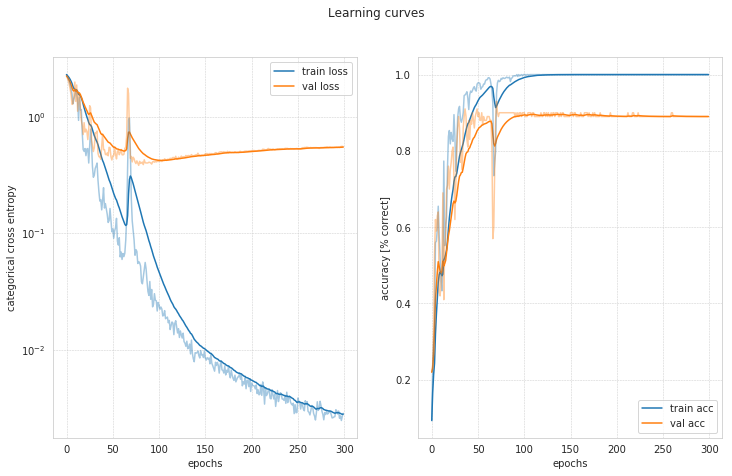

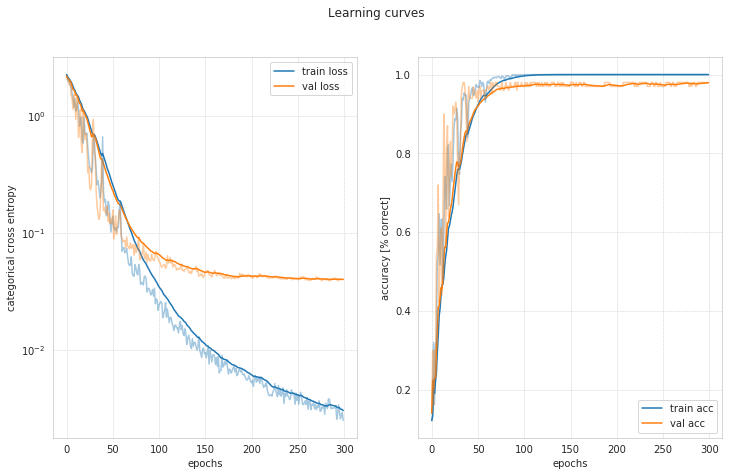

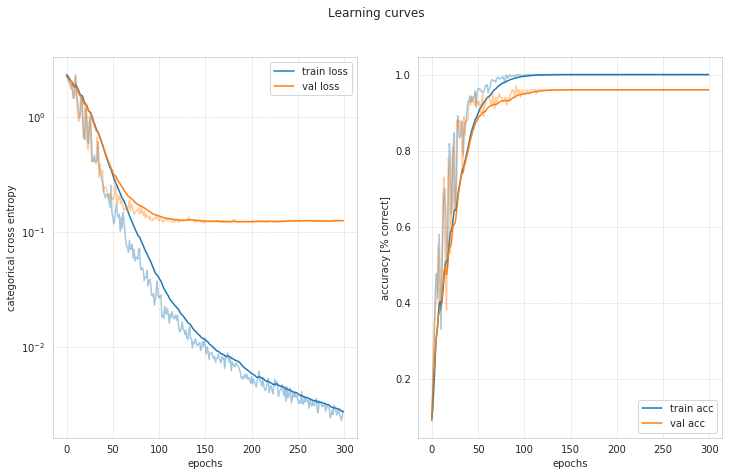

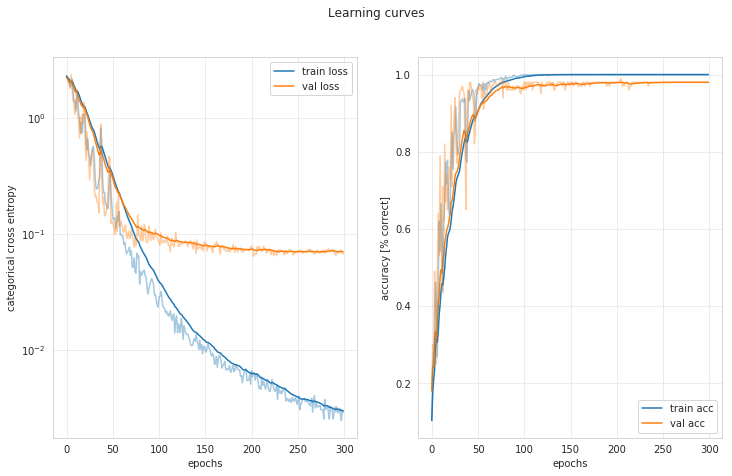

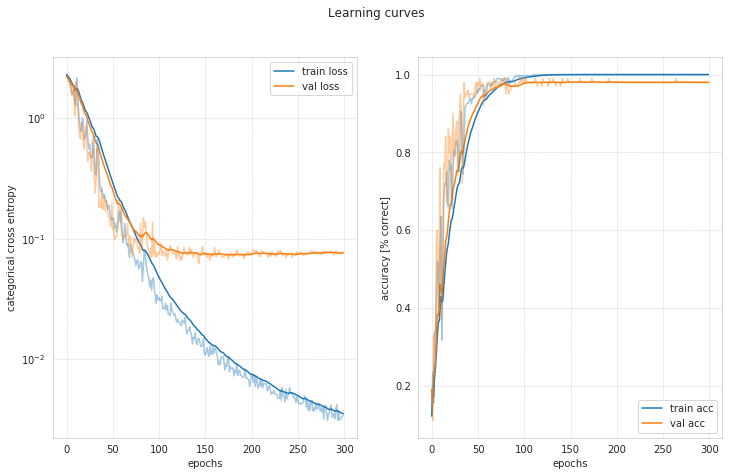

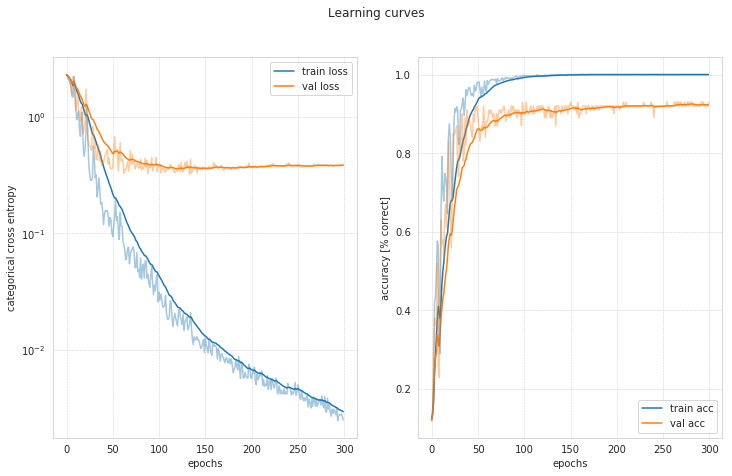

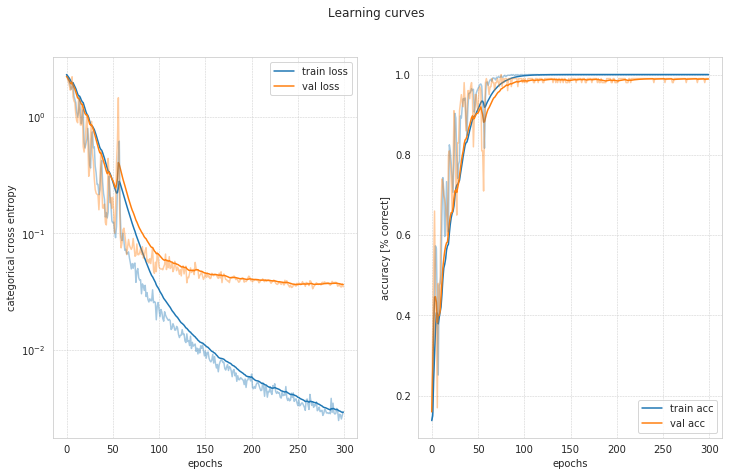

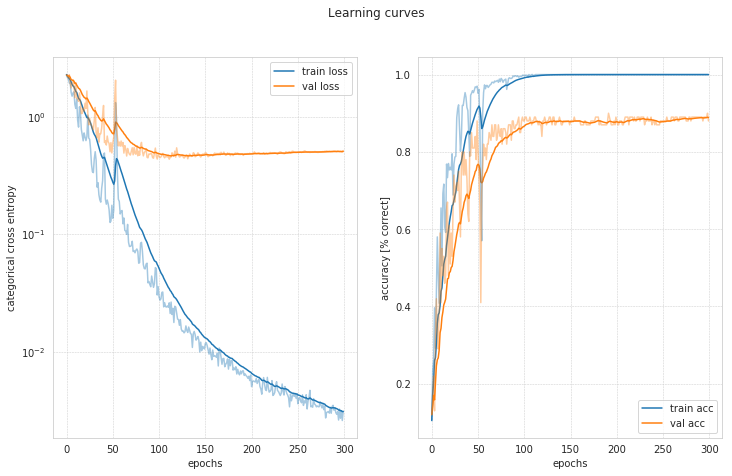

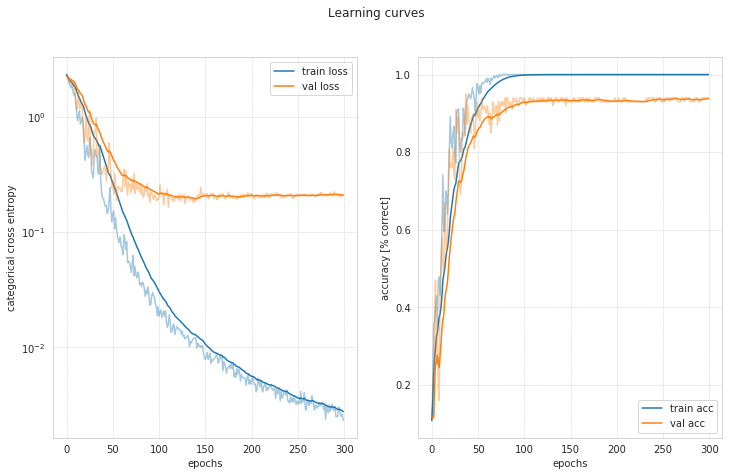

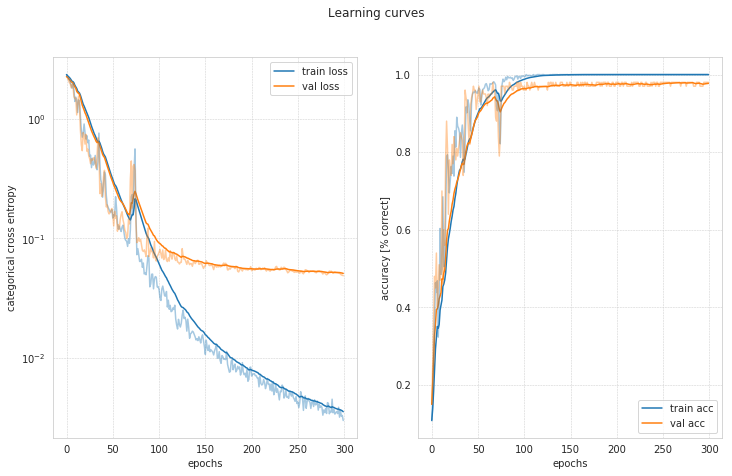

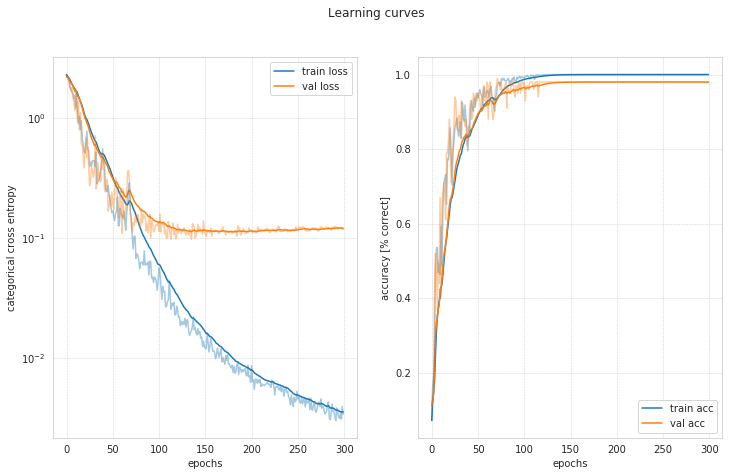

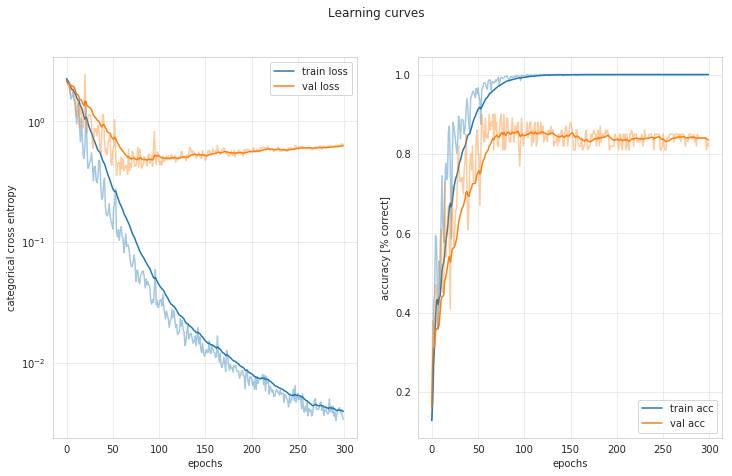

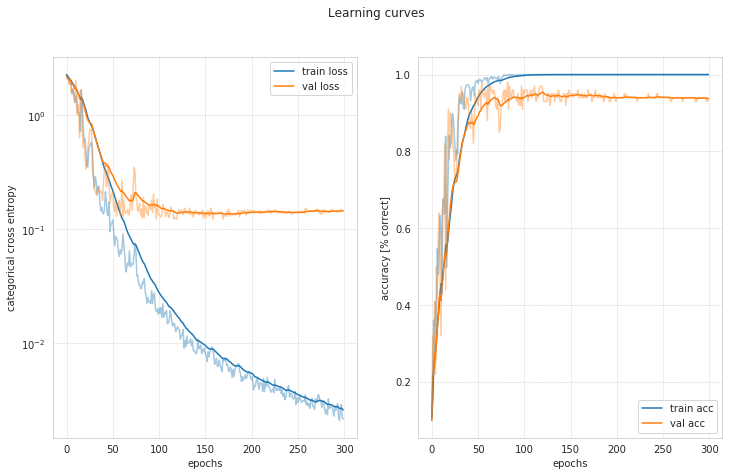

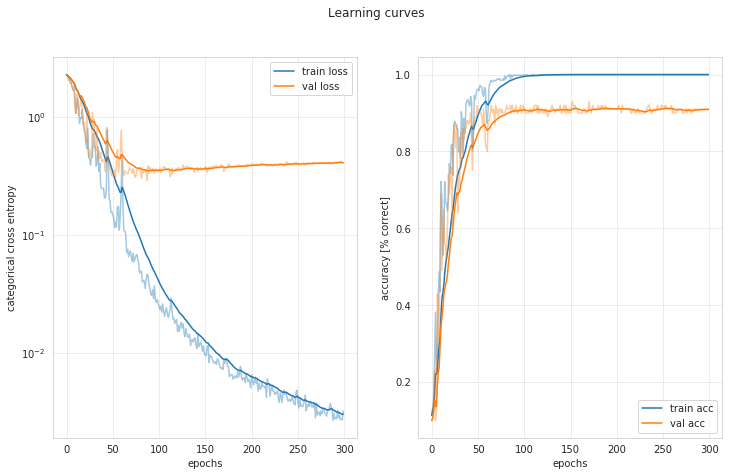

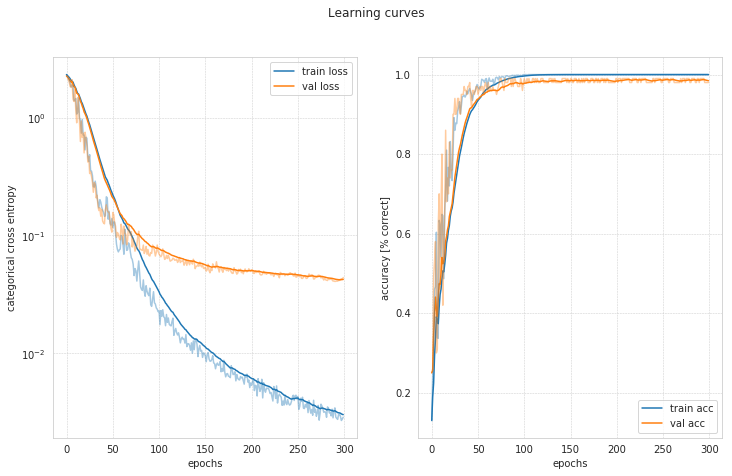

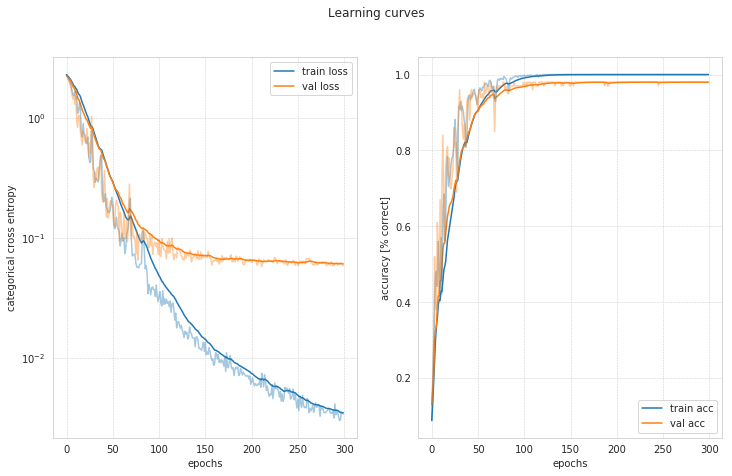

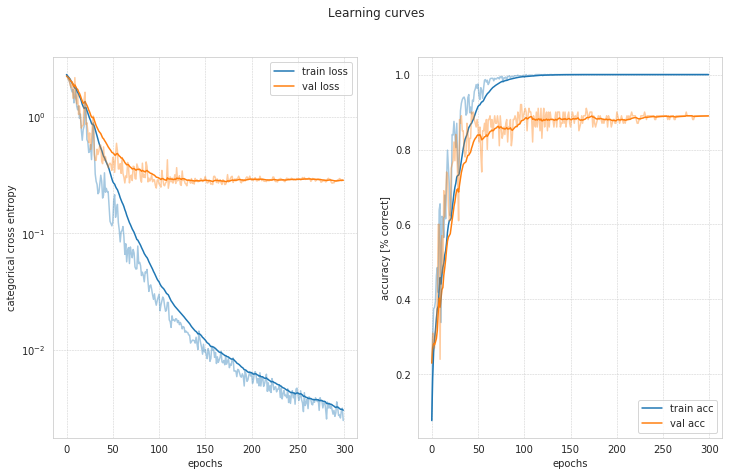

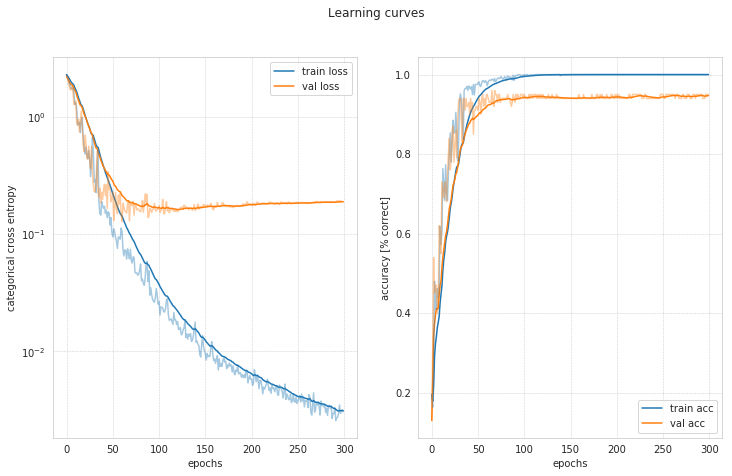

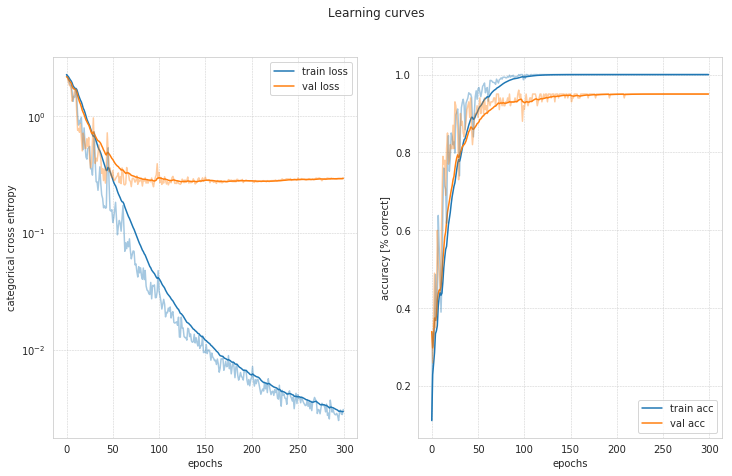

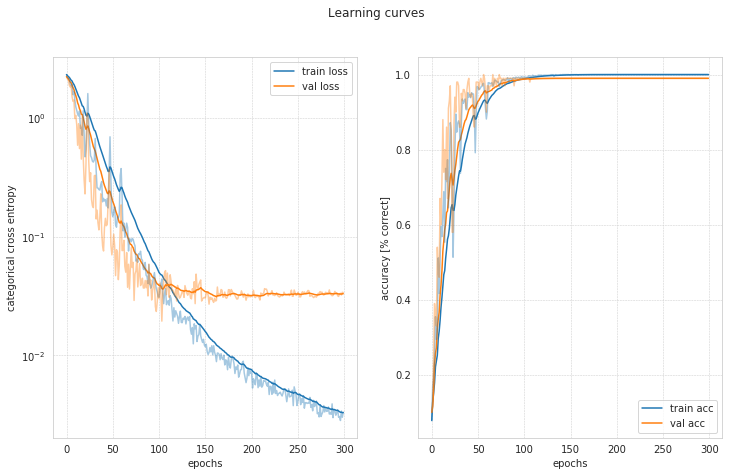

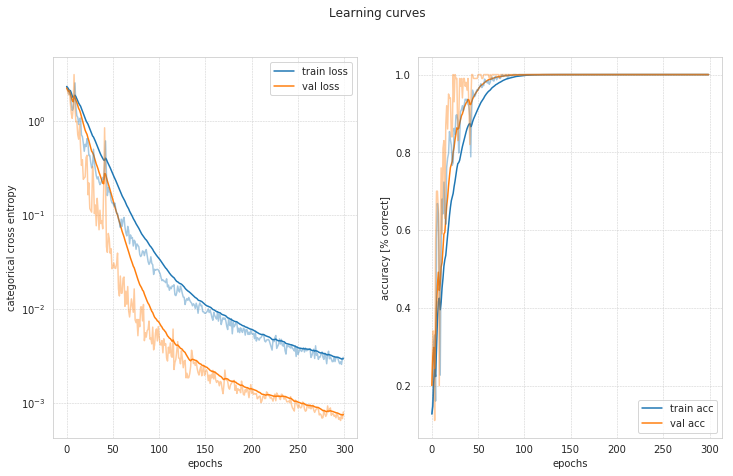

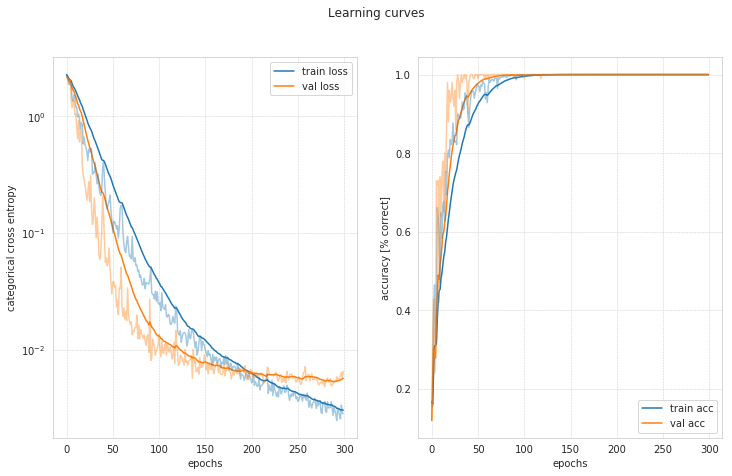

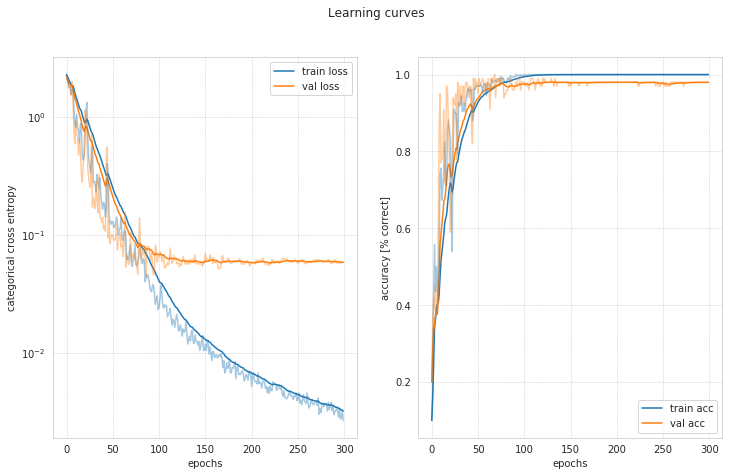

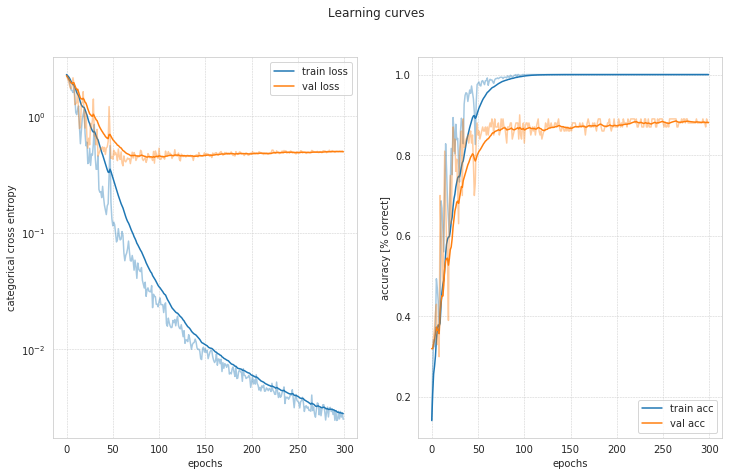

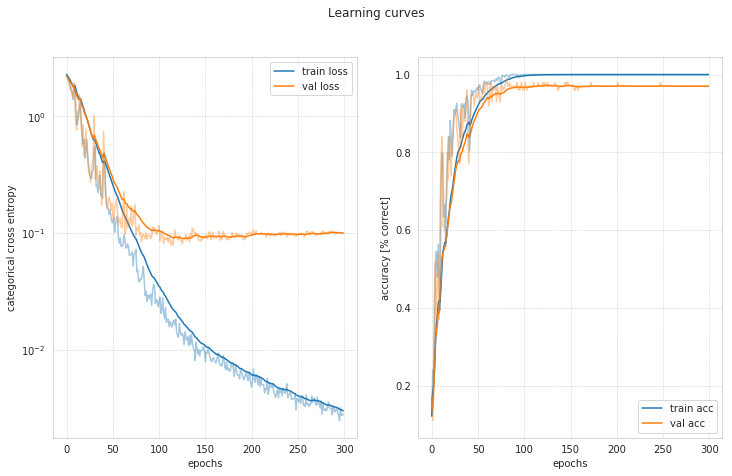

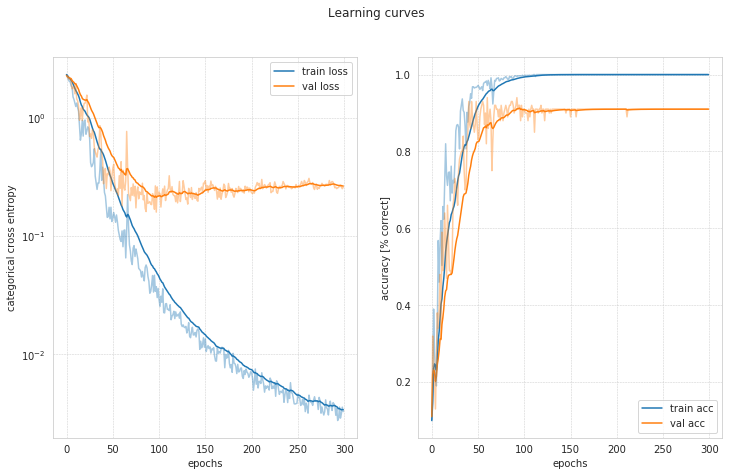

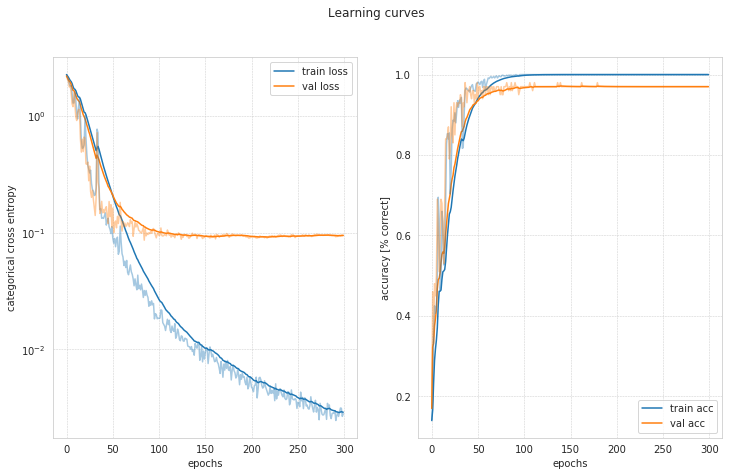

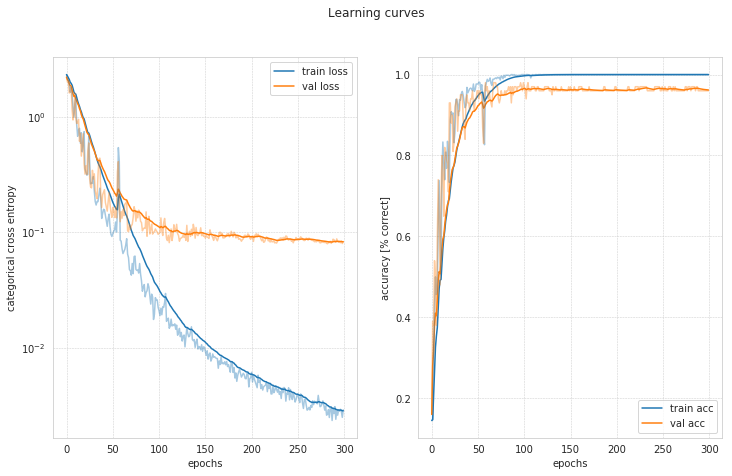

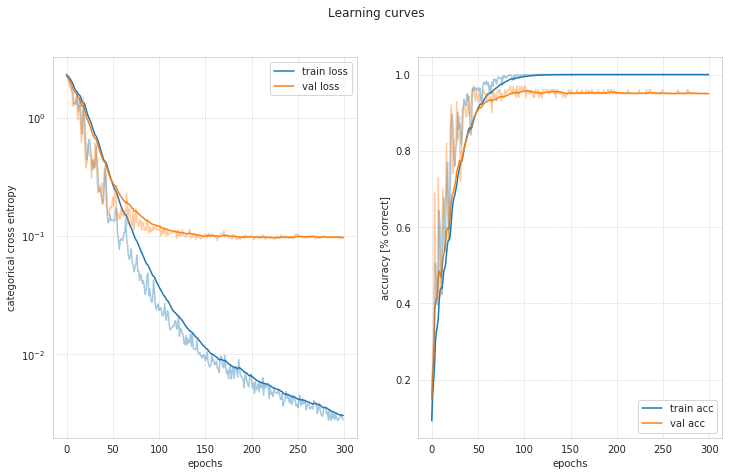

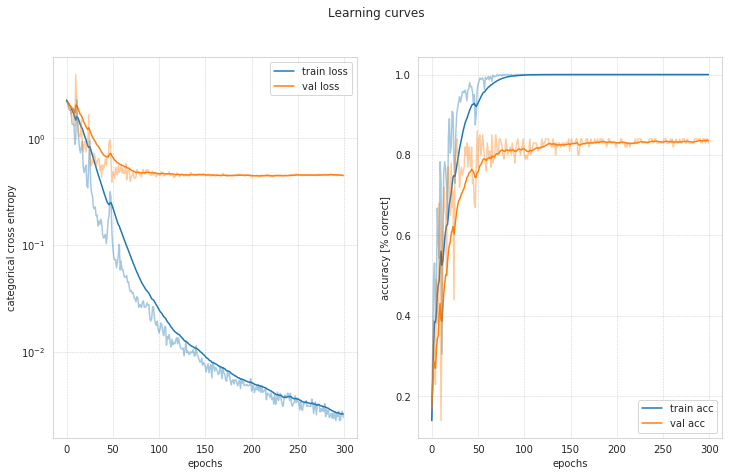

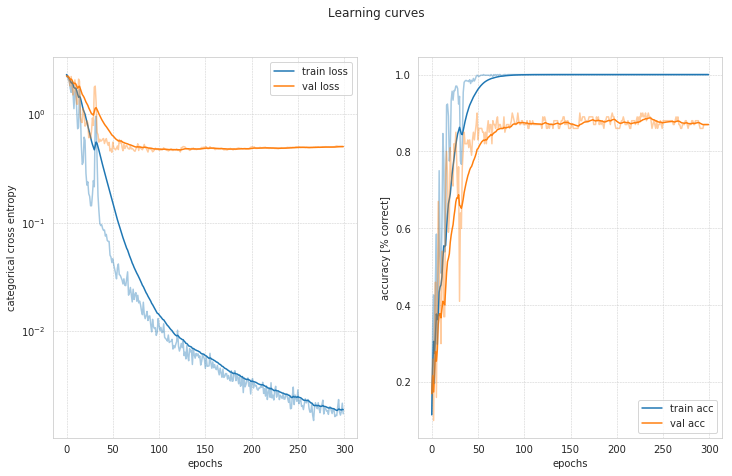

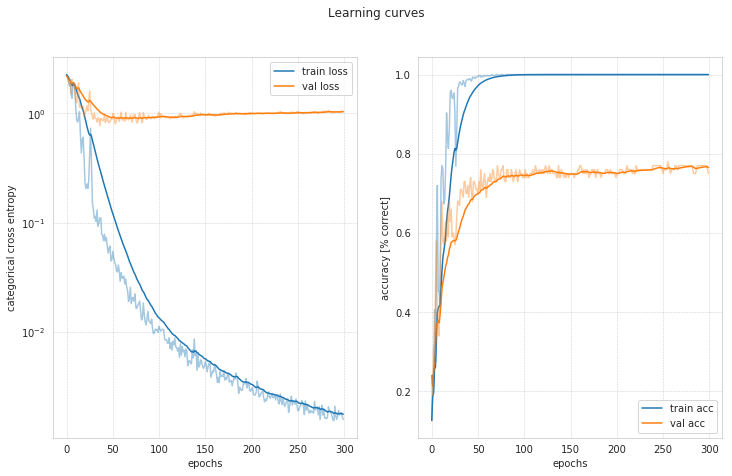

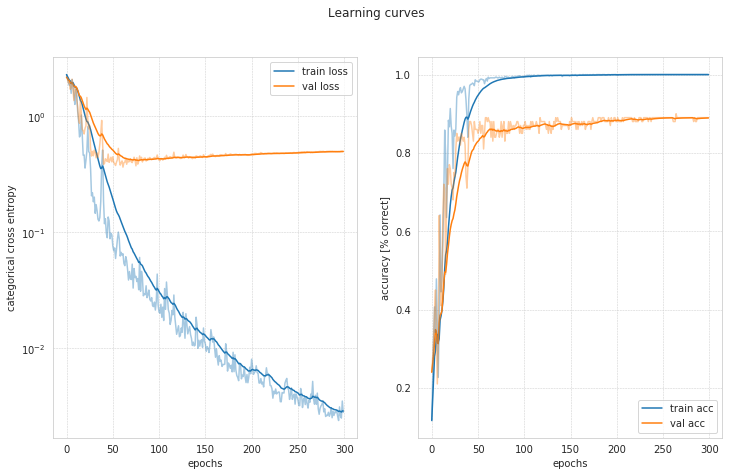

In [307]:
shadow_models = list()
nb_shadow_models = 100

(shadow_train_datasets, shadow_test_datasets) = \
    generate_n_shadow_models_datasets(nb_shadow_models, train_dataset, test_dataset)

for i in range(nb_shadow_models):
    print("training model", i)
    shadow_models.append(LeoNet())
    
    crit_fun = lambda input_, target : (input_, target)
    y_hat_fun = lambda y: y.argmax(1)

    loss_fun = nn.CrossEntropyLoss()
    learning_rate = 0.1
    
    mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun)
    hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=300, batch_size=500, verbose=0)
    mt.plot_training("Learning curves")

In [243]:
if not load_from_memory:
    save_model_state(model, 'model_F.pickle')

In [244]:
if load_from_memory:
    load_model_state(model, 'model_F.pickle')

## 2) Differentiate layer activation from training sample than one from a testing sample (per classes)

In [19]:
model.eval()

LeoNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (mxp1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (view): View(_, [-1])
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [20]:
model.fc1

Linear(in_features=576, out_features=32, bias=True)

In [21]:
layer = model.fc1
layer_name = "model.fc1"

In [22]:
g_train_dataset, g_test_dataset = \
generate_dataset_g_per_class(model, train_dataset, test_dataset, [layer], [layer_name], split=0.7) 

In [23]:
g_train_dataset[1][0].shape

torch.Size([1582, 1, 32])

In [24]:
choosen_class = 1
g_train_dataset = g_train_dataset[choosen_class]
g_test_dataset = g_test_dataset[choosen_class]

In [25]:
def kindaResnetG(layer_dim):
    dim = layer_dim[2]
    pad = (1, 1, 1)
    pool = 1
    finalVectorSize = layer_dim[2]//pool * layer_dim[3]//pool * layer_dim[4]//pool
    model = nn.Sequential(
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        #nn.BatchNorm3d(1),
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        #nn.BatchNorm3d(1),
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        #nn.BatchNorm3d(1),
        #nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        #nn.ReLU(),
        #nn.MaxPool3d(pool),

        View([-1]),
        nn.Linear(finalVectorSize, 128),
        nn.ReLU(),
        #nn.Linear(64, 128),
        #nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 2),  
    )
    return model


In [26]:
size_input_vector = g_train_dataset[0].shape
print("size of layer vector :", size_input_vector)

size of layer vector : torch.Size([1582, 1, 32])


In [27]:
g_target_weigths = torch.abs(1-computeClassesWeights(g_train_dataset[1]))
g_target_weigths

tensor([0.4981, 0.5019])

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.68197794           0.582      0.77435124           0.379
25                   0.64936000           0.630      0.82652032           0.376
50                   0.63378436           0.647      0.91863036           0.394
75                   0.63054572           0.649      0.82513785           0.397
100                  0.63794949           0.641      0.84243256           0.399
125                  0.64051770           0.637      0.81667644           0.416
150                  0.61188203           0.664      0.88800973           0.410
175                  0.61389796           0.669      0.88845259           0.415
200                  0.61876026           0.664      0.90322411           0.419
225                  0.61399725           0.662      1.00261652           0.421
250                  0.61981262         

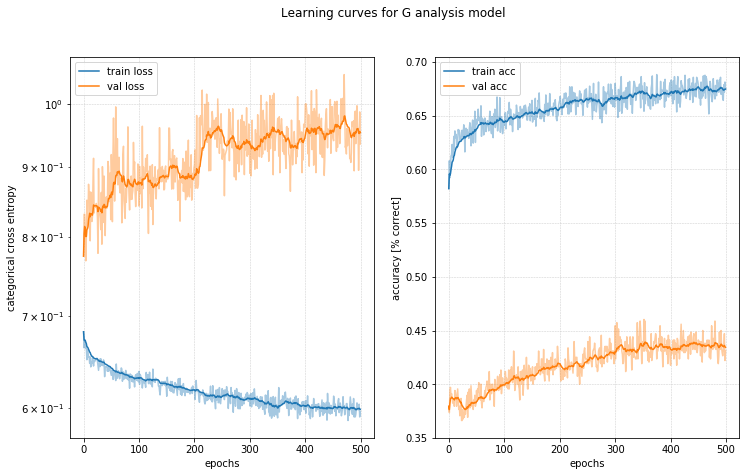

In [43]:
modelG = denseG(32)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss()#g_target_weigths)
learning_rate = 0.1
epochs = 500

mt = ModelTrainer(modelG, loss_fun, optim.SGD(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=epochs, batch_size=50, verbose=epochs/20)
mt.plot_training("Learning curves for G analysis model")

In [44]:
modelG.eval()
pass

In [45]:
positive_train = modelG(g_train_dataset[0][g_train_dataset[1] == 1]).softmax(1).detach().cpu().numpy()
negative_train = modelG(g_train_dataset[0][g_train_dataset[1] == 0]).softmax(1).detach().cpu().numpy()

positive_test = modelG(g_test_dataset[0][g_test_dataset[1] == 1]).softmax(1).detach().cpu().numpy()
negative_test = modelG(g_test_dataset[0][g_test_dataset[1] == 0]).softmax(1).detach().cpu().numpy()

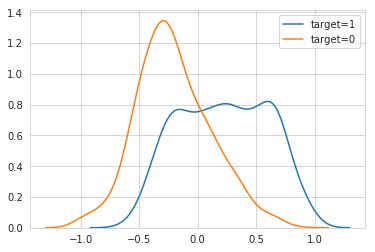

In [46]:
sns.set_style('whitegrid')
g = sns.kdeplot(positive_train[:, 1]-positive_train[:, 0], bw=0.1, label='target=1')
sns.kdeplot(negative_train[:, 1]-negative_train[:, 0], bw=0.1, ax=g, label='target=0')

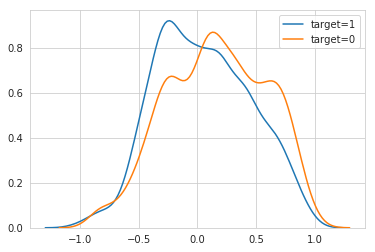

In [47]:
sns.set_style('whitegrid')
g = sns.kdeplot(positive_test[:, 1]-positive_test[:, 0], bw=0.1, label='target=1')
sns.kdeplot(negative_test[:, 1]-negative_test[:, 0], bw=0.1, ax=g, label='target=0')

In [48]:
print("false negative percentage :", 100 - 100*positive_test.argmax(1).sum()/positive_test.shape[0])
print("false positive percentage :", 100*negative_test.argmax(1).sum()/negative_test.shape[0])

false negative percentage : 48.67256637168141
false positive percentage : 65.10263929618769


In [63]:
sum(x.numel() for x in modelG.parameters())

7346

## 3) Same as 2) but with shadow models

In [308]:
for i in range(nb_shadow_models):
    shadow_models[i].eval()

In [309]:
shadow_models[0]

LeoNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (mxp1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (view): View(_, [-1])
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [310]:
layers = list()
layer_names = list()

for i in range(nb_shadow_models):
    layers.append(shadow_models[i].view)
    layer_names.append("shadow_model["+str(i)+"].view")

In [311]:
g_shadow_train_datasets, g_shadow_test_datasets = \
generate_dataset_g_per_class_from_shadows(shadow_models, shadow_train_datasets, shadow_test_datasets, layers, layer_names, split=0.8, nb_class=10)

In [312]:
g_shadow_test_datasets[6][0].shape

torch.Size([1455, 1, 576])

In [313]:
choosen_class = 0
g_shadow_train_dataset = g_shadow_train_datasets[choosen_class]
g_shadow_test_dataset = g_shadow_test_datasets[choosen_class]

g_shadow_train_dataset, g_shadow_test_dataset = normalize_data(g_shadow_train_dataset, g_shadow_test_dataset)

In [314]:
size_input_vector = g_shadow_train_dataset[0].shape
print("size of layer vector :", size_input_vector)
flattened_size = np.prod(np.array(g_shadow_train_dataset[0].shape[1:]))
print("size of flattened input (1 sample):", flattened_size)

size of layer vector : torch.Size([5441, 1, 576])
size of flattened input (1 sample): 576


In [315]:
g_shadow_target_weigths = torch.abs(1-computeClassesWeights(g_shadow_train_dataset[1]))
g_shadow_target_weigths = torch.Tensor([0.90, 0.1])

In [316]:
def denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.5),
        
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Dropout(0.3),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.BatchNorm1d(32),
        
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.BatchNorm1d(16),
        
        nn.Linear(16, 2)
    )
    return model

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.70416814           0.393      0.67307657           0.163
100                  0.57358081           0.469      0.63126808           0.309
200                  0.30052264           0.804      0.85500896           0.582
300                  0.16591537           0.906      1.21986163           0.667
400                  0.11752521           0.941      1.55100453           0.730
500                  0.08314359           0.958      1.72603285           0.758
600                  0.09255424           0.957      1.86594141           0.767
700                  0.07303233           0.969      1.95151401           0.781
800                  0.05101146           0.976      2.05939293           0.785
900                  0.06027024           0.972      2.06984591           0.781
1000                 0.05137131         

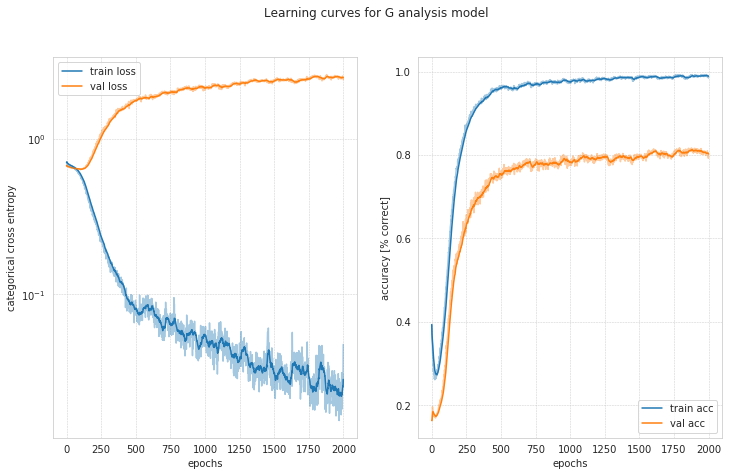

In [317]:
shadow_modelG = denseG(flattened_size)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(g_shadow_target_weigths)
learning_rate = 0.01
epochs = 2000

mt = ModelTrainer(shadow_modelG, loss_fun, optim.SGD(shadow_modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_shadow_train_dataset, g_shadow_test_dataset, epochs=epochs, batch_size=500, verbose=epochs/20)
mt.plot_training("Learning curves for G analysis model")

In [325]:
shadow_modelG.eval()
pass

In [326]:
positive_train = shadow_modelG(g_shadow_train_dataset[0][g_shadow_train_dataset[1] == 1]).softmax(1).detach().cpu().numpy()
negative_train = shadow_modelG(g_shadow_train_dataset[0][g_shadow_train_dataset[1] == 0]).softmax(1).detach().cpu().numpy()

positive_test = shadow_modelG(g_shadow_test_dataset[0][g_shadow_test_dataset[1] == 1]).softmax(1).detach().cpu().numpy()
negative_test = shadow_modelG(g_shadow_test_dataset[0][g_shadow_test_dataset[1] == 0]).softmax(1).detach().cpu().numpy()

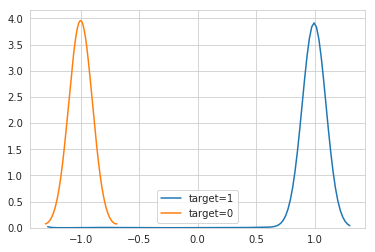

In [327]:
sns.set_style('whitegrid')
g = sns.kdeplot(positive_train[:, 1]-positive_train[:, 0], bw=0.1, label='target=1')
sns.kdeplot(negative_train[:, 1]-negative_train[:, 0], bw=0.1, ax=g, label='target=0')

In [328]:
#plt.hist((positive_train[:, 1]-positive_train[:, 0]), 30, density=True, histtype='step')
#plt.hist((negative_train[:, 1]-negative_train[:, 0]), 30, density=True, histtype='step')
#plt.legend(['target=1', 'target=0'])
pass

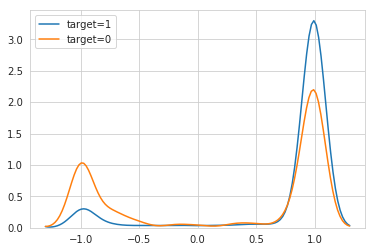

In [329]:
sns.set_style('whitegrid')
g = sns.kdeplot(positive_test[:, 1]-positive_test[:, 0], bw=0.1, label='target=1')
sns.kdeplot(negative_test[:, 1]-negative_test[:, 0], bw=0.1, ax=g, label='target=0')

In [330]:
#plt.hist((positive_test[:, 1]-positive_test[:, 0]), 30, density=True, histtype='step')
#plt.hist((negative_test[:, 1]-negative_test[:, 0]), 30, density=True, histtype='step')
#plt.legend(['target=1', 'target=0'])
pass

In [331]:
print("false negative percentage :", 100 - 100*positive_test.argmax(1).sum()/positive_test.shape[0])
print("false positive percentage :", 100*negative_test.argmax(1).sum()/negative_test.shape[0])

false negative percentage : 11.447260834014713
false positive percentage : 63.17991631799163
